# Chapter 6 Classifier Search

Different conditions for feature extraction: 

1. FFT Features only
2. FFT Features and DoE
3. Statistics only
4. Statistics and DoE
5. FFT Features and Statistics
6. FFT Features and statistics and DoE


In [1]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras
import tensorflow as tf

from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import OneClassSVM
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import describe

import matplotlib.colors as colors

from scipy import signal

from scipy.stats import probplot
from scipy.stats import normaltest

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

In [2]:
keras.backend.clear_session()
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


In [3]:
def extract_features(values):
    _,amps = signal.welch(values, fs=20e3, nperseg=4096, scaling='spectrum')
#     amps /= 0.01
    amps = lin_log_interp(amps)
    
    _,minmax,mean,variance,skewness,kurtosis = describe(values,axis=1)
    mean = mean[...,np.newaxis]
    variance = variance[...,np.newaxis]
    skewness = skewness[...,np.newaxis]
    kurtosis = kurtosis[...,np.newaxis]
    
    sampleRMS = np.sqrt(1 / values.shape[0] * np.sum((values - np.repeat(mean,values.shape[1],axis=1).reshape(mean.shape[0],values.shape[1]))**2,axis=1))
    sampleRMS = sampleRMS[...,np.newaxis]
    
    print(mean.shape,variance.shape,skewness.shape,kurtosis.shape,sampleRMS.shape)
    

    stats = np.hstack((mean,variance,skewness,kurtosis,sampleRMS))
        
    return amps,stats


def lin_log_interp(fft_features):
    '''
    Scale the fft features from the logarithmic axis to be approximately on 
    the interval from 0 to 1
    '''
    
    # Minimum exponent we expect to see in the data
    minimum = -12
    
    # Maximum exponent we expect to see
    maximum = 0
    
    # Number of points to use for interpolation
    numpoints = 1000
    
    # Map the logarithmic x-axis to a linear y-axis
    x = np.logspace(minimum,maximum,numpoints)
    y = np.linspace(0,1,numpoints)

    # Return the interpolated valuess
    return np.interp(np.log10(fft_features),np.log10(x),y)

In [4]:
DoE_test = np.loadtxt('Experiment-3-Data/DoE_test_pruned.txt',delimiter=',')
DoE_train = np.loadtxt('Experiment-3-Data/DoE_train_pruned.txt',delimiter=',')

trainDF = pd.read_csv('Experiment-3-Data/Vib_train_pruned.csv')
testDF = pd.read_csv('Experiment-3-Data/Vib_test_pruned.csv')

X_train = trainDF.loc[:, trainDF.columns != 'dateTime'].values.astype(np.float32)
X_test = testDF.loc[:, testDF.columns != 'dateTime'].values.astype(np.float32)
Y_train = np.loadtxt('Experiment-3-Data/Y_train_pruned.txt',delimiter=',')
Y_test = np.loadtxt('Experiment-3-Data/Y_test_pruned.txt',delimiter=',')

first_good_train = np.argwhere(Y_train[:,0] == 0).flatten()[0]
first_good_test = np.argwhere(Y_test[:,0] == 0).flatten()[0]

X_train_original,stats_train_original = extract_features(X_train,)
X_test_original,stats_test_original = extract_features(X_test,)

stats_train_unhealthy = stats_train_original[first_good_train:,:]
stats_valid_unhealthy = stats_test_original[first_good_test:,:]
stats_train_healthy = stats_train_original[:first_good_train,:]
stats_valid_healthy = stats_test_original[:first_good_test,:]


X_train_unhealthy = X_train_original[first_good_train:,:]
X_valid_unhealthy = X_test_original[first_good_test:,:]
X_train_healthy = X_train_original[:first_good_train,:]
X_valid_healthy = X_test_original[:first_good_test,:]

DoE_train_healthy = DoE_train[:first_good_train,:]
DoE_train_unhealthy = DoE_train[first_good_train:,:]
DoE_test_healthy = DoE_test[:first_good_test,:]
DoE_test_unhealthy = DoE_test[first_good_test:,:]


Y_train_healthy = np.tile(np.array([[1]]),(X_train_healthy.shape[0],1))
Y_valid_healthy = np.tile(np.array([[1]]),(X_valid_healthy.shape[0],1))
Y_train_unhealthy = np.tile(np.array([[0]]),(X_train_unhealthy.shape[0],1))
Y_valid_unhealthy = np.tile(np.array([[0]]),(X_valid_unhealthy.shape[0],1))

XY_train_healthy = np.hstack((X_train_healthy,Y_train_healthy))
XY_valid_healthy = np.hstack((X_valid_healthy,Y_valid_healthy))
XY_train_unhealthy = np.hstack((X_train_unhealthy,Y_train_unhealthy))
XY_valid_unhealthy = np.hstack((X_valid_unhealthy,Y_valid_unhealthy))

XY_train = np.vstack((XY_train_healthy,XY_train_unhealthy))
XY_valid = np.vstack((XY_valid_healthy,XY_valid_unhealthy))

stats_train = np.vstack((stats_train_healthy,stats_train_unhealthy))
stats_valid = np.vstack((stats_valid_healthy,stats_valid_unhealthy))

Y_train = XY_train[:,-1]
Y_valid = XY_valid[:,-1]
columns = ['Healthy Train','Healthy Valid','Unhealthy Train','Unhealthy Valid']

X = []
X.append(X_train_healthy)
X.append(X_valid_healthy)
X.append(X_train_unhealthy)
X.append(X_valid_unhealthy)

DoE = []
DoE.append(DoE_train_healthy)
DoE.append(DoE_test_healthy)
DoE.append(DoE_train_unhealthy)
DoE.append(DoE_test_unhealthy)

stats = []
stats.append(stats_train_healthy)
stats.append(stats_valid_healthy)
stats.append(stats_train_unhealthy)
stats.append(stats_valid_unhealthy)
freqs = np.linspace(0,10000,2048)


(306, 1) (306, 1) (306, 1) (306, 1) (306, 1)
(151, 1) (151, 1) (151, 1) (151, 1) (151, 1)


In [5]:
def fit_statistics(y_true, y_pred):

    conf_matrix = np.round(confusion_matrix(y_true, y_pred) / y_pred.shape[0],2)
    
    # Null hypothesis: tool is healthy
    # Positive: Tool is unhealthy
    # Negative: Tool is healthy
    
    true_positive = conf_matrix[0,0]
    true_negative = conf_matrix[1,1]
    
    # False positive: tool is actually healthy but classified as unhealthy
    # | - | X |
    # | - | - |
    false_positive = conf_matrix[0,1]
    
    # False negative: tool is actually unhealthy but classified as healthy
    # | - | - |
    # | X | - |
    false_negative = conf_matrix[1,0]
    
    # Precision: Quantifies false positives
    # Recall: Quantifies false negatives
    
    if true_positive == 0 and false_positive == 0.:
        precision = 0.
    else:
        precision = true_positive / (true_positive + false_positive)
    
    if true_positive == 0. and false_negative == 0.:
        recall = 0.
        true_positive_rate = 0.
    else:
        recall = true_positive / (true_positive + false_negative)
        true_positive_rate = true_positive / (true_positive + false_negative)

    if true_negative == 0. and false_positive == 0.:
        true_negative_rate = 0.
    else:
        true_negative_rate = true_negative / (true_negative + false_positive)
    
    balanced_accuracy = (true_positive_rate + true_negative_rate) / 2
    
    return balanced_accuracy, true_positive_rate, true_negative_rate, precision, recall
 

def plot_confusion_matrix(y_true,y_pred,
                          labels,
                          filename='confusion_matrix'):
    
    predict_label = labels
    true_label = labels.copy()
    
    
    predict_label.insert(0, '')

    conf_matrix = np.round(confusion_matrix(y_true, y_pred) / y_pred.shape[0],2)
    
    # Null hypothesis: tool is healthy
    # Positive: Tool is unhealthy
    # Negative: Tool is healthy
    
    true_positive = conf_matrix[0,0]
    true_negative = conf_matrix[1,1]
    
    # False positive: tool is actually healthy but classified as unhealthy
    # | - | X |
    # | - | - |
    false_positive = conf_matrix[0,1]
    
    # False negative: tool is actually unhealthy but classified as healthy
    # | - | - |
    # | X | - |
    false_negative = conf_matrix[1,0]
    
    # It is better to investigate something and conclude it is healthy
    # than let an unhealthy tool go unnoticed. For this reason, false
    # positives are considered less costly than false negatives
    
    # Precision: Quantifies false positives
    # Recall: Quantifies false negatives
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    
    true_positive_rate = true_positive / (true_positive + false_negative)
    true_negative_rate = true_negative / (true_negative + false_positive)
    
    balanced_accuracy = (true_positive_rate + true_negative_rate) / 2

    fig = plt.figure()
    ax = plt.gca()
    im = ax.matshow(conf_matrix,cmap='gray',norm=colors.Normalize(vmin=0.,vmax=.5))

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(true_label)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(true_label)
    ax.set_yticklabels(predict_label)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ylabel = 'Actual State'
    xlabel = 'Predicted State'
    xlabelpad = 5

    plt.xlabel(r'\textbf{' + xlabel + '}', labelpad=xlabelpad)
    plt.ylabel(r'\textbf{' + ylabel + '}', labelpad=5)

    # Loop over data dimensions and create text annotations.
    for i in range(len(predict_label)-1):
        for j in range(len(true_label)):
            text_color = 'w'
            if conf_matrix[i,j] > 0.25:
                text_color = 'k'
            text = ax.text(j, i, r'\textbf{' + str(conf_matrix[i, j]) + '}',fontsize=22,
                           ha="center", va="center", color=text_color)

    cbar = plt.colorbar(im)
    cbar.set_label(r'\textbf{Occurrence Fraction}', rotation=270,labelpad=20)
    plt.tight_layout()
    plt.savefig('figures/' + filename + '.png',transparent=True)  
    plt.show()
    
    return balanced_accuracy, true_positive_rate, true_negative_rate, precision, recall

In [6]:
DoE_train.shape
DoE_test.shape

(151, 3)

In [38]:
precision_recall = np.zeros((126,510,4))
precision_recall_columns = ['Train Precision','Train Recall','Valid Precision','Valid Recall']

DoE_shape = 2
stats_shape = 0

for i in range(2,128):
    for j in range(2,512):
        
        max_fft = j
        pca_components = i
        
        X_train = np.hstack((XY_train[:,:max_fft],stats_train[:,:stats_shape],DoE_train[:,:DoE_shape]))
        X_valid = np.hstack((XY_valid[:,:max_fft],stats_valid[:,:stats_shape],DoE_test[:,:DoE_shape]))
        
        if pca_components >= X_train.shape[1]:
            pca_components = X_train.shape[1] - 1
            
        estimators = [ ('reduce_dim', PCA(n_components=pca_components)), ('gnb', GaussianNB())]

        pipe = Pipeline(estimators)
        pipe.fit(X_train,Y_train)
        Y_valid_pred = pipe.predict(X_valid)
        Y_train_pred = pipe.predict(X_train)

        fit_train = fit_statistics(Y_train, Y_train_pred)
        fit_valid = fit_statistics(Y_valid, Y_valid_pred)

        precision_recall[i-2,j-2,:] = np.array([fit_train[-2],fit_train[-1],fit_valid[-2],fit_valid[-1]])


KeyboardInterrupt: 

In [7]:
print(XY_train.shape)
print(X_train.shape)
print(fit_valid)

(306, 2050)
(306, 4200)


NameError: name 'fit_valid' is not defined

In [8]:
train_score = np.sum(precision_recall[...,:2]**2,axis=-1)
valid_score = np.sum(precision_recall[...,2:]**2,axis=-1)
combined_score = (valid_score**2) + (train_score**2)
# np.save('data/precision_recall_noscaling_withStats_noDoE.npy',precision_recall)

NameError: name 'precision_recall' is not defined

In [35]:
print(np.amin(train_score))
print(np.amax(train_score))
print(np.amin(valid_score))
# print(np.amax(valid_score))


0.0
2.0
0.0


In [2]:
DoE_shape = 0
precision_recall = np.load('data/precision_recall_noscaling_DoE-RPM-IPT.npy',allow_pickle=True)

train_precision = precision_recall[...,0]
train_recall = precision_recall[...,1]
valid_precision = precision_recall[...,2]
valid_recall = precision_recall[...,3]

train_score = 2 * np.nan_to_num((train_precision * train_recall) / (train_precision + train_recall))
valid_score = 2 * np.nan_to_num((valid_precision * valid_recall) / (valid_precision + valid_recall))

# train_score = np.sum(precision_recall[...,:2]**2,axis=-1)
# valid_score = np.sum(precision_recall[...,2:]**2,axis=-1)
combined_score = (valid_score)**2 + (train_score)**2
combined_score /= 2
freqs = np.linspace(0,10000,2048)

/home/dnewman/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/dnewman/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [3]:
print(combined_score.flatten()[np.argmax(combined_score)])
print(train_score.flatten()[np.argmax(combined_score)])
print(valid_score.flatten()[np.argmax(combined_score)])
# print(np.argmax(combined_score))
# print(np.argmax(combined_score) % combined_score.shape[1])
# print(int(np.floor(np.argmax(combined_score) / combined_score.shape[1])))
# print(valid_score[29,np.argmax(combined_score) % combined_score.shape[1]])
# print(train_score[9,245])

best_pca = int(np.floor(np.argmax(combined_score) / combined_score.shape[1])) + 2
best_fft = np.argmax(combined_score) % combined_score.shape[1] + 2

print(best_pca)
print(best_fft)

0.948753462603878
1.0
0.9473684210526315
36
458


In [11]:
best_fft

NameError: name 'best_fft' is not defined

In [24]:
yi = np.arange(-0.0, valid_score.shape[0])
xi = np.arange(0.0,valid_score.shape[1])

X, Y = np.meshgrid(xi, yi)

# print(X.shape)
# print(Y.shape)
# print(spectrogram.shape)

# Customize the axes
print(yi.shape)
print(xi.shape)
print(X.shape)
print(Y.shape)

(126,)
(510,)
(126, 510)
(126, 510)


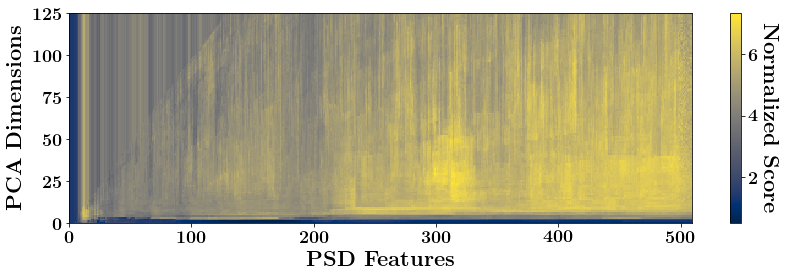

In [25]:
plt.figure(figsize=(12,4))
ax = plt.gca()
plt.pcolormesh(X,Y,combined_score,cmap='cividis',norm=colors.Normalize(vmin=np.amin(combined_score),vmax=np.amax(combined_score)))
cbar = plt.colorbar()
cbar.set_label(r'\textbf{Normalized Score}', rotation=270,labelpad=20)
plt.ylabel(r'\textbf{PCA Dimensions}', labelpad=5,fontsize=22)
plt.xlabel(r'\textbf{PSD Features}', labelpad=5,fontsize=22)

plt.tight_layout(pad=1.2)

plt.show()

In [26]:
# estimators = [('scaler',StandardScaler()), ('reduce_dim', PCA(n_components=9)), ('gnb', GaussianNB())]
max_fft = best_fft
pca_components = best_pca

X_train = np.hstack((XY_train[:,:max_fft],DoE_train[:,:DoE_shape]))
X_valid = np.hstack((XY_valid[:,:max_fft],DoE_test[:,:DoE_shape]))


estimators = [('reduce_dim', PCA(n_components=pca_components)), ('gnb', GaussianNB())]

# estimators = [('reduce_dim', KernelPCA(n_components=32,kernel='rbf')), ('gmm', GaussianMixture())]

pipe = Pipeline(estimators)
pipe.fit(X_train,Y_train)

Y_valid_pred = pipe.predict(X_valid)
conf_matrix_valid = confusion_matrix(Y_valid, Y_valid_pred)
accuracy_valid = np.sum(np.diagonal(conf_matrix_valid)) / np.sum(conf_matrix_valid)
print(conf_matrix_valid)
print(accuracy_valid)

Y_train_pred = pipe.predict(X_train)
conf_matrix_train = confusion_matrix(Y_train, Y_train_pred)
accuracy_train = np.sum(np.diagonal(conf_matrix_train)) / np.sum(conf_matrix_train)
print(conf_matrix_train)
print(accuracy_train)

dump(pipe, 'data/pca_gnb.joblib') 

[[83  3]
 [ 4 61]]
0.9536423841059603
[[149   1]
 [  1 155]]
0.9934640522875817


['data/pca_gnb.joblib']

In [71]:
np.hstack((X_train_original[:,:262],DoE_train[:,:DoE_shape])).shape

(306, 264)

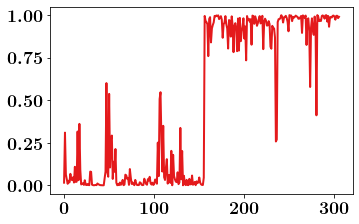

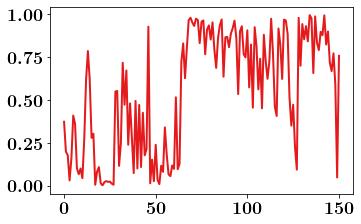

In [72]:
plt.plot(pipe.predict_proba(np.hstack((X_train_original[:,:max_fft],DoE_train[:,:DoE_shape])))[:,0])
plt.show()

plt.plot(pipe.predict_proba(np.hstack((X_test_original[:,:max_fft],DoE_test[:,:DoE_shape])))[:,0])
plt.show()

No handles with labels found to put in legend.


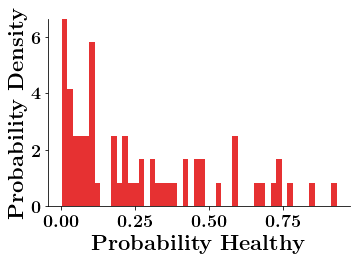

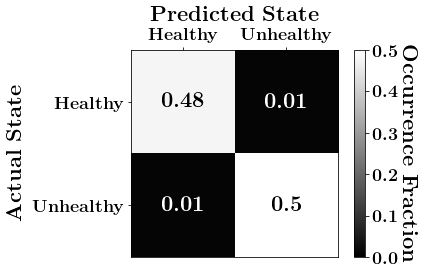

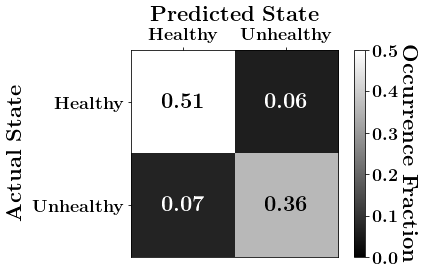

No handles with labels found to put in legend.


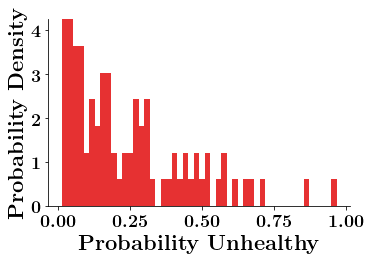

(0.9799919967987194, 0.9795918367346939, 0.9803921568627451, 0.9795918367346939, 0.9795918367346939)
(0.8682266009852215, 0.8793103448275861, 0.8571428571428571, 0.894736842105263, 0.8793103448275861)


In [73]:
# pipe.predict_proba(X_train_healthy)[:,0]

responses= np.vstack((
                       pipe.predict_proba(X_valid_healthy[:,:max_fft + DoE_shape])[:,0]))
genplt.plot_histogram(responses,[''],
               'Probability Healthy',
               'Probability Density',
               'pca_gnb_predict_healthy',
               template='publication',
               legend_loc='upper left',
               ymax=0.0,
               num_col=1,
               nbins=50)

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'pca_gnb_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'pca_gnb_confmatrix_valid'
                       )

responses= np.vstack((
                       pipe.predict_proba(X_valid_unhealthy[:,:max_fft + DoE_shape])[:,1]))
genplt.plot_histogram(responses,[''],
               'Probability Unhealthy',
               'Probability Density',
               'pca_gnb_predict_unhealthy',
               template='publication',
               legend_loc='upper left',
               ymax=0.0,
               num_col=1,
               nbins=50)

print(balanced_train_accuracy)
print(balanced_valid_accuracy)

In [26]:
import numpy as np

import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization

from ML_Train.Custom_Layers import Dropout_Live
import kerastuner as kt

def build_hp_classifier(hp):
    
    mlp = Sequential()
    mlp.add(Input(shape=int(best_pca)))
    mlp.add(Flatten())
    
    for i in range(hp.Int('hidden_layers', 1, 5, step=1)):
        mlp.add(Dense(hp.Int('filters_' + str(i), 4, 64, step=4), activation='relu'))
        mlp.add(BatchNormalization())
        mlp.add(Dropout(hp.Float('dropout_rate_' + str(i), 0.0, 0.5, step=0.1)))
        
    mlp.add(Dense(2,activation='softmax'))
    
    mlp.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
        
    return mlp

Using TensorFlow backend.


In [165]:
DoE_shape=3

In [166]:


X_train = np.hstack((XY_train[:,:best_fft],DoE_train[:,:DoE_shape]))
X_valid = np.hstack((XY_valid[:,:best_fft],DoE_test[:,:DoE_shape]))

pca = PCA(n_components = best_pca)

X_train = pca.fit_transform(X_train)
X_valid = pca.transform(X_valid)

tuner = kt.Hyperband(
    build_hp_classifier,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=4,
    directory='fft_classifier',
    project_name='mlp_fft_classifier')

tuner.search(X_train,np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
             validation_data=(X_valid,np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

INFO:tensorflow:Reloading Oracle from existing project fft_classifier/mlp_fft_classifier/oracle.json
Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.8172 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.6800 - accuracy: 0.5752 - val_loss: 0.6828 - val_accuracy: 0.6556
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.4851 - accuracy: 0.68 - 0s 162us/sample - loss: 0.4426 - accuracy: 0.7647 - val_loss: 0.6818 - val_accuracy: 0.6424


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 0.6519 - accuracy: 0.65 - 1s 2ms/sample - loss: 0.7482 - accuracy: 0.5327 - val_loss: 0.7090 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7017 - accuracy: 0.50 - 0s 172us/sample - loss: 0.6585 - accuracy: 0.5915 - val_loss: 0.6963 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.8987 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.7466 - accuracy: 0.6046 - val_loss: 0.7096 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5409 - accuracy: 0.62 - 0s 205us/sample - loss: 0.5521 - accuracy: 0.7157 - val_loss: 0.6759 - val_accuracy: 0.5960


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.3206 - accuracy: 0.50 - 1s 2ms/sample - loss: 1.2703 - accuracy: 0.5098 - val_loss: 0.6935 - val_accuracy: 0.5099
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9903 - accuracy: 0.46 - 0s 208us/sample - loss: 0.9457 - accuracy: 0.5327 - val_loss: 0.6899 - val_accuracy: 0.5364


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.8817 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.8956 - accuracy: 0.5523 - val_loss: 0.6929 - val_accuracy: 0.5497
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.1943 - accuracy: 0.31 - 0s 189us/sample - loss: 0.8474 - accuracy: 0.5523 - val_loss: 0.6919 - val_accuracy: 0.5762


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 0.7581 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.7105 - accuracy: 0.6699 - val_loss: 0.6791 - val_accuracy: 0.6954
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.96 - 0s 134us/sample - loss: 0.2343 - accuracy: 0.8987 - val_loss: 0.6745 - val_accuracy: 0.6887


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.4000 - accuracy: 0.40 - 1s 2ms/sample - loss: 1.1890 - accuracy: 0.4837 - val_loss: 0.6963 - val_accuracy: 0.4901
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.0824 - accuracy: 0.62 - 0s 156us/sample - loss: 1.1659 - accuracy: 0.4869 - val_loss: 0.7004 - val_accuracy: 0.4371


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 0.9096 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.4327 - accuracy: 0.8007 - val_loss: 0.6294 - val_accuracy: 0.6026
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.0970 - accuracy: 0.96 - 0s 166us/sample - loss: 0.0894 - accuracy: 0.9673 - val_loss: 0.5266 - val_accuracy: 0.8278


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.0941 - accuracy: 0.40 - 1s 2ms/sample - loss: 0.6943 - accuracy: 0.6340 - val_loss: 0.6918 - val_accuracy: 0.5960
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.2778 - accuracy: 0.93 - 0s 220us/sample - loss: 0.2927 - accuracy: 0.8824 - val_loss: 0.6286 - val_accuracy: 0.8278


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 0.8266 - accuracy: 0.56 - 1s 2ms/sample - loss: 1.0760 - accuracy: 0.5294 - val_loss: 0.6968 - val_accuracy: 0.4768
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5810 - accuracy: 0.65 - 0s 136us/sample - loss: 1.0298 - accuracy: 0.5458 - val_loss: 0.6981 - val_accuracy: 0.4570


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.3834 - accuracy: 0.59 - 1s 2ms/sample - loss: 1.1022 - accuracy: 0.6046 - val_loss: 0.6995 - val_accuracy: 0.4636
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9500 - accuracy: 0.59 - 0s 128us/sample - loss: 1.1662 - accuracy: 0.5654 - val_loss: 0.7193 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 0.7013 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.5835 - accuracy: 0.6928 - val_loss: 0.6872 - val_accuracy: 0.5033
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.3128 - accuracy: 0.96 - 0s 132us/sample - loss: 0.3482 - accuracy: 0.9118 - val_loss: 0.6856 - val_accuracy: 0.4371


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.4347 - accuracy: 0.37 - 1s 2ms/sample - loss: 1.1332 - accuracy: 0.5294 - val_loss: 0.6846 - val_accuracy: 0.5232
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7070 - accuracy: 0.62 - 0s 151us/sample - loss: 0.7702 - accuracy: 0.6667 - val_loss: 0.6870 - val_accuracy: 0.4503


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.9744 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.7834 - accuracy: 0.6046 - val_loss: 0.6860 - val_accuracy: 0.5894
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6733 - accuracy: 0.62 - 0s 189us/sample - loss: 0.5302 - accuracy: 0.7451 - val_loss: 0.6812 - val_accuracy: 0.7682


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.1577 - accuracy: 0.37 - 1s 2ms/sample - loss: 1.0173 - accuracy: 0.4673 - val_loss: 0.6920 - val_accuracy: 0.5166
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.2438 - accuracy: 0.40 - 0s 164us/sample - loss: 1.0692 - accuracy: 0.5425 - val_loss: 0.6968 - val_accuracy: 0.4371


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.7411 - accuracy: 0.59 - 1s 2ms/sample - loss: 1.0587 - accuracy: 0.4771 - val_loss: 0.6917 - val_accuracy: 0.5894
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.2584 - accuracy: 0.40 - 0s 163us/sample - loss: 1.1122 - accuracy: 0.4575 - val_loss: 0.6949 - val_accuracy: 0.4503


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.3602 - accuracy: 0.40 - 1s 2ms/sample - loss: 0.4768 - accuracy: 0.8039 - val_loss: 0.6787 - val_accuracy: 0.4437
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.1384 - accuracy: 0.96 - 0s 172us/sample - loss: 0.1859 - accuracy: 0.9248 - val_loss: 0.7222 - val_accuracy: 0.4570


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 0.9585 - accuracy: 0.50 - 1s 2ms/sample - loss: 1.0780 - accuracy: 0.5196 - val_loss: 0.6863 - val_accuracy: 0.5497
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9141 - accuracy: 0.62 - 0s 176us/sample - loss: 1.0044 - accuracy: 0.5556 - val_loss: 0.6805 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.6978 - accuracy: 0.62 - 1s 2ms/sample - loss: 0.8147 - accuracy: 0.5621 - val_loss: 0.6892 - val_accuracy: 0.6225
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.75 - 0s 157us/sample - loss: 0.6895 - accuracy: 0.6536 - val_loss: 0.6906 - val_accuracy: 0.4834


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.9806 - accuracy: 0.50 - 1s 2ms/sample - loss: 1.1674 - accuracy: 0.4673 - val_loss: 0.6888 - val_accuracy: 0.5762
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8503 - accuracy: 0.56 - 0s 166us/sample - loss: 0.9814 - accuracy: 0.5294 - val_loss: 0.6887 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 1.2050 - accuracy: 0.53 - 0s 1ms/sample - loss: 0.3487 - accuracy: 0.8595 - val_loss: 0.6241 - val_accuracy: 0.7152
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.1657 - accuracy: 0.93 - 0s 114us/sample - loss: 0.0696 - accuracy: 0.9739 - val_loss: 0.7394 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 1.3814 - accuracy: 0.56 - 0s 1ms/sample - loss: 0.6352 - accuracy: 0.7386 - val_loss: 0.6271 - val_accuracy: 0.8278
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.4131 - accuracy: 0.84 - 0s 150us/sample - loss: 0.2083 - accuracy: 0.9150 - val_loss: 0.5721 - val_accuracy: 0.9205


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.3978 - accuracy: 0.31 - 1s 2ms/sample - loss: 1.3950 - accuracy: 0.4412 - val_loss: 0.6938 - val_accuracy: 0.5166
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.6334 - accuracy: 0.37 - 0s 185us/sample - loss: 1.2026 - accuracy: 0.5359 - val_loss: 0.6943 - val_accuracy: 0.4371


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.1943 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.0314 - accuracy: 0.5392 - val_loss: 0.7065 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6171 - accuracy: 0.75 - 0s 184us/sample - loss: 1.0354 - accuracy: 0.5392 - val_loss: 0.7239 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.9667 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.9310 - accuracy: 0.5000 - val_loss: 0.6953 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.0294 - accuracy: 0.43 - 0s 155us/sample - loss: 0.8664 - accuracy: 0.5784 - val_loss: 0.6986 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.5285 - accuracy: 0.34 - 1s 2ms/sample - loss: 0.8482 - accuracy: 0.6405 - val_loss: 0.6896 - val_accuracy: 0.5166
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.3519 - accuracy: 0.87 - 0s 158us/sample - loss: 0.4005 - accuracy: 0.8137 - val_loss: 0.6914 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.4708 - accuracy: 0.53 - 1s 3ms/sample - loss: 0.8863 - accuracy: 0.6275 - val_loss: 0.6944 - val_accuracy: 0.4636
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6275 - accuracy: 0.68 - 0s 233us/sample - loss: 0.4913 - accuracy: 0.7941 - val_loss: 0.6612 - val_accuracy: 0.6358


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.8420 - accuracy: 0.37 - 1s 2ms/sample - loss: 1.4150 - accuracy: 0.4444 - val_loss: 0.6947 - val_accuracy: 0.4570
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.4786 - accuracy: 0.50 - 0s 155us/sample - loss: 1.2953 - accuracy: 0.5033 - val_loss: 0.6982 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.0492 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.5805 - accuracy: 0.7353 - val_loss: 0.6708 - val_accuracy: 0.5430
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.2490 - accuracy: 0.90 - 0s 204us/sample - loss: 0.1855 - accuracy: 0.9150 - val_loss: 0.6596 - val_accuracy: 0.5563


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.9477 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.9736 - accuracy: 0.5065 - val_loss: 0.7057 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9946 - accuracy: 0.59 - 0s 169us/sample - loss: 0.9791 - accuracy: 0.5131 - val_loss: 0.7211 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 1.3172 - accuracy: 0.50 - 0s 1ms/sample - loss: 1.1637 - accuracy: 0.5523 - val_loss: 0.6938 - val_accuracy: 0.4636
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8553 - accuracy: 0.50 - 0s 115us/sample - loss: 1.1497 - accuracy: 0.5359 - val_loss: 0.6938 - val_accuracy: 0.4503


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.8227 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.9434 - accuracy: 0.5327 - val_loss: 0.6938 - val_accuracy: 0.4768
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7395 - accuracy: 0.75 - 0s 156us/sample - loss: 0.6981 - accuracy: 0.6405 - val_loss: 0.6949 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 0.8205 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.9668 - accuracy: 0.5196 - val_loss: 0.6961 - val_accuracy: 0.5298
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8614 - accuracy: 0.56 - 0s 178us/sample - loss: 0.9049 - accuracy: 0.5425 - val_loss: 0.6938 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.3427 - accuracy: 0.50 - 1s 2ms/sample - loss: 1.0757 - accuracy: 0.4967 - val_loss: 0.6925 - val_accuracy: 0.4967
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.1109 - accuracy: 0.46 - 0s 152us/sample - loss: 0.9686 - accuracy: 0.5490 - val_loss: 0.6970 - val_accuracy: 0.4834


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 2s - loss: 0.7734 - accuracy: 0.62 - 0s 1ms/sample - loss: 0.6216 - accuracy: 0.7386 - val_loss: 0.6541 - val_accuracy: 0.7483
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.2722 - accuracy: 0.87 - 0s 143us/sample - loss: 0.1974 - accuracy: 0.9118 - val_loss: 0.6019 - val_accuracy: 0.8079


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 0.7685 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.3195 - accuracy: 0.8660 - val_loss: 0.6505 - val_accuracy: 0.4834
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 1.00 - 0s 173us/sample - loss: 0.0726 - accuracy: 0.9739 - val_loss: 0.5612 - val_accuracy: 0.6689


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.0259 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.6539 - accuracy: 0.6863 - val_loss: 0.6875 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.5075 - accuracy: 0.81 - 0s 225us/sample - loss: 0.2936 - accuracy: 0.8889 - val_loss: 0.6006 - val_accuracy: 0.8212


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.0224 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.8623 - accuracy: 0.5490 - val_loss: 0.6938 - val_accuracy: 0.4570
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.5394 - accuracy: 0.78 - 0s 215us/sample - loss: 0.4979 - accuracy: 0.7516 - val_loss: 0.6854 - val_accuracy: 0.6490


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 2s - loss: 0.9536 - accuracy: 0.53 - 0s 1ms/sample - loss: 0.3707 - accuracy: 0.8529 - val_loss: 0.6899 - val_accuracy: 0.4305
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.3575 - accuracy: 0.81 - 0s 153us/sample - loss: 0.1387 - accuracy: 0.9510 - val_loss: 0.6357 - val_accuracy: 0.5430


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 0.7947 - accuracy: 0.71 - 1s 2ms/sample - loss: 0.7376 - accuracy: 0.6667 - val_loss: 0.6886 - val_accuracy: 0.5828
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.3844 - accuracy: 0.84 - 0s 173us/sample - loss: 0.2828 - accuracy: 0.8791 - val_loss: 0.6782 - val_accuracy: 0.7020


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 0.9225 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.7287 - accuracy: 0.6275 - val_loss: 0.6926 - val_accuracy: 0.5762
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.4651 - accuracy: 0.84 - 0s 159us/sample - loss: 0.4783 - accuracy: 0.7941 - val_loss: 0.6960 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.4319 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.9869 - accuracy: 0.5686 - val_loss: 0.7149 - val_accuracy: 0.4371
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.6041 - accuracy: 0.75 - 0s 226us/sample - loss: 0.5163 - accuracy: 0.7484 - val_loss: 0.6967 - val_accuracy: 0.5364


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.0826 - accuracy: 0.56 - 1s 2ms/sample - loss: 1.1409 - accuracy: 0.4869 - val_loss: 0.6889 - val_accuracy: 0.5430
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 1.0586 - accuracy: 0.56 - 0s 162us/sample - loss: 1.1848 - accuracy: 0.5000 - val_loss: 0.6904 - val_accuracy: 0.5364


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 0.8970 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.6993 - accuracy: 0.6307 - val_loss: 0.6897 - val_accuracy: 0.5497
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.5353 - accuracy: 0.75 - 0s 212us/sample - loss: 0.4614 - accuracy: 0.7680 - val_loss: 0.6665 - val_accuracy: 0.6755


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.2019 - accuracy: 0.56 - 1s 2ms/sample - loss: 1.1414 - accuracy: 0.5425 - val_loss: 0.6965 - val_accuracy: 0.4503
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.7039 - accuracy: 0.56 - 0s 198us/sample - loss: 1.0947 - accuracy: 0.5588 - val_loss: 0.6941 - val_accuracy: 0.5166


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 0.9979 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.9859 - accuracy: 0.5359 - val_loss: 0.6875 - val_accuracy: 0.6358
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.7453 - accuracy: 0.68 - 0s 154us/sample - loss: 1.0371 - accuracy: 0.5229 - val_loss: 0.6923 - val_accuracy: 0.4834


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 1.3863 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.7204 - accuracy: 0.6601 - val_loss: 0.7123 - val_accuracy: 0.4437
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.2249 - accuracy: 0.90 - 0s 222us/sample - loss: 0.1745 - accuracy: 0.9510 - val_loss: 0.6374 - val_accuracy: 0.6358
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.93 - 0s 235us/sample - loss: 0.1084 - accuracy: 0.9673 - val_loss: 0.5645 - val_accuracy: 0.7550
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.4852 - accuracy: 0.87 - 0s 227us/sample - loss: 0.1260 - accuracy: 0.9608 - val_loss: 0.4575 - val_accuracy: 0.8411
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.0680 - accuracy: 0.96 - 0s 172us/sample - loss: 0.1113 - accuracy: 0.9510 - val_loss: 0.4684 - val_accuracy: 0.7947


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 2s - loss: 0.8653 - accuracy: 0.65 - 0s 1ms/sample - loss: 0.5999 - accuracy: 0.7190 - val_loss: 0.6594 - val_accuracy: 0.5629
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.4677 - accuracy: 0.87 - 0s 160us/sample - loss: 0.2122 - accuracy: 0.9281 - val_loss: 0.6188 - val_accuracy: 0.5695
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.0853 - accuracy: 1.00 - 0s 159us/sample - loss: 0.0900 - accuracy: 0.9641 - val_loss: 0.5656 - val_accuracy: 0.6689
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.96 - 0s 147us/sample - loss: 0.0487 - accuracy: 0.9837 - val_loss: 0.4966 - val_accuracy: 0.8411
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.96 - 0s 158us/sample - loss: 0.0614 - accuracy: 0.9706 - val_loss: 0.4334 - val_accuracy: 0.9073
Epoch 10/10
306/

Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 0.9396 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.7547 - accuracy: 0.6732 - val_loss: 0.6810 - val_accuracy: 0.5695
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.1894 - accuracy: 0.93 - 0s 173us/sample - loss: 0.2671 - accuracy: 0.8954 - val_loss: 0.6644 - val_accuracy: 0.6026
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 1.00 - 0s 174us/sample - loss: 0.1807 - accuracy: 0.9346 - val_loss: 0.6538 - val_accuracy: 0.8013
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.93 - 0s 135us/sample - loss: 0.0877 - accuracy: 0.9739 - val_loss: 0.6473 - val_accuracy: 0.7881
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 1.00 - 0s 139us/sample - loss: 0.0628 - accuracy: 0.9869 - val_loss: 0.6464 - val_accuracy: 0.6623
Epoch 10/10
306/

Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 1.0453 - accuracy: 0.43 - 1s 2ms/sample - loss: 0.8041 - accuracy: 0.5392 - val_loss: 0.7016 - val_accuracy: 0.4305
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.53 - 0s 212us/sample - loss: 0.6172 - accuracy: 0.6634 - val_loss: 0.6918 - val_accuracy: 0.5497
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.3579 - accuracy: 0.84 - 0s 206us/sample - loss: 0.4860 - accuracy: 0.7582 - val_loss: 0.6806 - val_accuracy: 0.5894
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.3476 - accuracy: 0.81 - 0s 213us/sample - loss: 0.3246 - accuracy: 0.8595 - val_loss: 0.6292 - val_accuracy: 0.6689
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.90 - 0s 203us/sample - loss: 0.2074 - accuracy: 0.9118 - val_loss: 0.5562 - val_accuracy: 0.8079
Epoch 10/10
306/

Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 2s - loss: 1.4547 - accuracy: 0.46 - 0s 1ms/sample - loss: 0.7139 - accuracy: 0.7124 - val_loss: 0.6508 - val_accuracy: 0.7550
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.84 - 0s 125us/sample - loss: 0.1805 - accuracy: 0.9314 - val_loss: 0.6602 - val_accuracy: 0.4967


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 0.8274 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.7380 - accuracy: 0.6340 - val_loss: 0.6792 - val_accuracy: 0.5695
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.5991 - accuracy: 0.81 - 0s 154us/sample - loss: 0.5906 - accuracy: 0.7157 - val_loss: 0.6896 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 1.1959 - accuracy: 0.50 - 1s 2ms/sample - loss: 1.2072 - accuracy: 0.4935 - val_loss: 0.6973 - val_accuracy: 0.4570
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.3209 - accuracy: 0.31 - 0s 158us/sample - loss: 1.1958 - accuracy: 0.5098 - val_loss: 0.7086 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.5347 - accuracy: 0.34 - 1s 2ms/sample - loss: 0.6463 - accuracy: 0.6928 - val_loss: 0.7043 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.3877 - accuracy: 0.81 - 0s 179us/sample - loss: 0.1984 - accuracy: 0.9314 - val_loss: 0.6386 - val_accuracy: 0.7616
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.1943 - accuracy: 0.96 - 0s 184us/sample - loss: 0.1353 - accuracy: 0.9477 - val_loss: 0.5748 - val_accuracy: 0.7881
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.0395 - accuracy: 1.00 - 0s 162us/sample - loss: 0.0617 - accuracy: 0.9804 - val_loss: 0.5188 - val_accuracy: 0.8278


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 2s - loss: 1.0857 - accuracy: 0.46 - 0s 1ms/sample - loss: 1.1346 - accuracy: 0.4314 - val_loss: 0.7034 - val_accuracy: 0.3775
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.1282 - accuracy: 0.40 - 0s 122us/sample - loss: 0.9177 - accuracy: 0.5196 - val_loss: 0.7049 - val_accuracy: 0.3775


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 2s - loss: 1.3816 - accuracy: 0.56 - 0s 1ms/sample - loss: 1.0599 - accuracy: 0.5654 - val_loss: 0.6894 - val_accuracy: 0.5563
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.8982 - accuracy: 0.62 - 0s 143us/sample - loss: 0.9467 - accuracy: 0.5719 - val_loss: 0.6876 - val_accuracy: 0.5960
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 1.2495 - accuracy: 0.56 - 0s 130us/sample - loss: 1.0760 - accuracy: 0.5458 - val_loss: 0.6862 - val_accuracy: 0.5960
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.6899 - accuracy: 0.68 - 0s 122us/sample - loss: 1.0262 - accuracy: 0.5458 - val_loss: 0.6848 - val_accuracy: 0.5960


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 1.1730 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.8386 - accuracy: 0.6340 - val_loss: 0.6922 - val_accuracy: 0.5894
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.4925 - accuracy: 0.75 - 0s 167us/sample - loss: 0.3740 - accuracy: 0.8399 - val_loss: 0.6862 - val_accuracy: 0.5762
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.3632 - accuracy: 0.81 - 0s 153us/sample - loss: 0.2850 - accuracy: 0.9052 - val_loss: 0.6812 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.3450 - accuracy: 0.81 - 0s 157us/sample - loss: 0.2359 - accuracy: 0.9085 - val_loss: 0.6772 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.2849 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.8217 - accuracy: 0.6405 - val_loss: 0.6979 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.6255 - accuracy: 0.62 - 0s 184us/sample - loss: 0.4490 - accuracy: 0.8072 - val_loss: 0.6834 - val_accuracy: 0.4371
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.1692 - accuracy: 0.96 - 0s 183us/sample - loss: 0.2341 - accuracy: 0.9183 - val_loss: 0.6738 - val_accuracy: 0.4967
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.93 - 0s 179us/sample - loss: 0.1859 - accuracy: 0.9379 - val_loss: 0.6684 - val_accuracy: 0.5629


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.1126 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.5236 - accuracy: 0.7516 - val_loss: 0.6309 - val_accuracy: 0.8411
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.2437 - accuracy: 0.96 - 0s 139us/sample - loss: 0.1881 - accuracy: 0.9673 - val_loss: 0.6253 - val_accuracy: 0.6159
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.1788 - accuracy: 0.93 - 0s 135us/sample - loss: 0.1356 - accuracy: 0.9706 - val_loss: 0.5769 - val_accuracy: 0.6424
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.0646 - accuracy: 1.00 - 0s 143us/sample - loss: 0.0644 - accuracy: 0.9837 - val_loss: 0.6227 - val_accuracy: 0.5430


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 1.8711 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.8516 - accuracy: 0.6438 - val_loss: 0.6869 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.4387 - accuracy: 0.78 - 0s 237us/sample - loss: 0.3792 - accuracy: 0.8399 - val_loss: 0.6314 - val_accuracy: 0.8543
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.3080 - accuracy: 0.90 - 0s 182us/sample - loss: 0.2701 - accuracy: 0.9085 - val_loss: 0.5884 - val_accuracy: 0.7682
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.2591 - accuracy: 0.87 - 0s 171us/sample - loss: 0.1889 - accuracy: 0.9281 - val_loss: 0.5296 - val_accuracy: 0.7881


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 1.2938 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.6232 - accuracy: 0.6863 - val_loss: 0.6341 - val_accuracy: 0.6093
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.1846 - accuracy: 0.90 - 0s 199us/sample - loss: 0.1878 - accuracy: 0.9379 - val_loss: 0.5146 - val_accuracy: 0.8344
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.1203 - accuracy: 0.96 - 0s 157us/sample - loss: 0.0787 - accuracy: 0.9706 - val_loss: 0.4561 - val_accuracy: 0.7219
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.1892 - accuracy: 0.93 - 0s 161us/sample - loss: 0.0436 - accuracy: 0.9902 - val_loss: 0.4378 - val_accuracy: 0.7550


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 0.8590 - accuracy: 0.65 - 1s 2ms/sample - loss: 0.4816 - accuracy: 0.8007 - val_loss: 0.6586 - val_accuracy: 0.5430
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.3186 - accuracy: 0.84 - 0s 140us/sample - loss: 0.2326 - accuracy: 0.8954 - val_loss: 0.7516 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 0.8914 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.6607 - accuracy: 0.7026 - val_loss: 0.6564 - val_accuracy: 0.5695
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.2467 - accuracy: 0.93 - 0s 224us/sample - loss: 0.2494 - accuracy: 0.9085 - val_loss: 0.5482 - val_accuracy: 0.8278
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.93 - 0s 225us/sample - loss: 0.1019 - accuracy: 0.9771 - val_loss: 0.3886 - val_accuracy: 0.9007
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 1.00 - 0s 157us/sample - loss: 0.0784 - accuracy: 0.9739 - val_loss: 0.4392 - val_accuracy: 0.8146


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 2s - loss: 1.0376 - accuracy: 0.50 - 0s 1ms/sample - loss: 1.2214 - accuracy: 0.4804 - val_loss: 0.7006 - val_accuracy: 0.4371
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.0287 - accuracy: 0.50 - 0s 111us/sample - loss: 1.1271 - accuracy: 0.4869 - val_loss: 0.6960 - val_accuracy: 0.4305
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.9462 - accuracy: 0.59 - 0s 156us/sample - loss: 1.0155 - accuracy: 0.5000 - val_loss: 0.6916 - val_accuracy: 0.4967
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 1.0395 - accuracy: 0.46 - 0s 140us/sample - loss: 0.8943 - accuracy: 0.5392 - val_loss: 0.6880 - val_accuracy: 0.5497


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 0.9713 - accuracy: 0.46 - 1s 2ms/sample - loss: 1.0707 - accuracy: 0.5261 - val_loss: 0.7049 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.8685 - accuracy: 0.62 - 0s 179us/sample - loss: 0.9105 - accuracy: 0.6144 - val_loss: 0.7034 - val_accuracy: 0.4305
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.7016 - accuracy: 0.68 - 0s 176us/sample - loss: 0.8277 - accuracy: 0.5654 - val_loss: 0.7038 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.2284 - accuracy: 0.50 - 1s 2ms/sample - loss: 1.1108 - accuracy: 0.5425 - val_loss: 0.7077 - val_accuracy: 0.4437
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.2096 - accuracy: 0.53 - 0s 190us/sample - loss: 1.1361 - accuracy: 0.5359 - val_loss: 0.7113 - val_accuracy: 0.5232


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 1.1135 - accuracy: 0.31 - 1s 2ms/sample - loss: 1.0390 - accuracy: 0.4379 - val_loss: 0.6930 - val_accuracy: 0.5430
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.8502 - accuracy: 0.56 - 0s 231us/sample - loss: 0.9747 - accuracy: 0.4837 - val_loss: 0.6921 - val_accuracy: 0.5695
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 1.1360 - accuracy: 0.43 - 0s 185us/sample - loss: 0.9488 - accuracy: 0.5098 - val_loss: 0.6916 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.8759 - accuracy: 0.56 - 0s 174us/sample - loss: 0.9990 - accuracy: 0.4673 - val_loss: 0.6914 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 1.1143 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.7425 - accuracy: 0.6667 - val_loss: 0.6428 - val_accuracy: 0.6358
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.93 - 0s 199us/sample - loss: 0.2248 - accuracy: 0.9346 - val_loss: 0.5514 - val_accuracy: 0.9007
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 1.00 - 0s 162us/sample - loss: 0.1000 - accuracy: 0.9641 - val_loss: 0.4740 - val_accuracy: 0.8940
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 1.00 - 0s 159us/sample - loss: 0.0823 - accuracy: 0.9771 - val_loss: 0.3858 - val_accuracy: 0.8808
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 1.00 - 0s 173us/sample - loss: 0.0674 - accuracy: 0.9804 - val_loss: 0.4232 - val_accuracy: 0.7616


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 1.1633 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.7915 - accuracy: 0.6078 - val_loss: 0.6931 - val_accuracy: 0.6623
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.5399 - accuracy: 0.68 - 0s 178us/sample - loss: 0.3982 - accuracy: 0.8268 - val_loss: 0.6880 - val_accuracy: 0.6358
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.3460 - accuracy: 0.90 - 0s 184us/sample - loss: 0.2767 - accuracy: 0.9216 - val_loss: 0.6631 - val_accuracy: 0.6556
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.1706 - accuracy: 0.93 - 0s 233us/sample - loss: 0.2115 - accuracy: 0.9150 - val_loss: 0.5997 - val_accuracy: 0.7682
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.1526 - accuracy: 0.96 - 0s 252us/sample - loss: 0.1428 - accuracy: 0.9673 - val_loss: 0.4904 - val_accuracy: 0.8543
Epoch 10/10
306/

Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 1.2343 - accuracy: 0.37 - 1s 2ms/sample - loss: 0.6041 - accuracy: 0.6895 - val_loss: 0.6707 - val_accuracy: 0.5695
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.3161 - accuracy: 0.87 - 0s 177us/sample - loss: 0.2713 - accuracy: 0.8987 - val_loss: 0.6011 - val_accuracy: 0.6556
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.90 - 0s 137us/sample - loss: 0.1302 - accuracy: 0.9739 - val_loss: 0.5726 - val_accuracy: 0.5894
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.0598 - accuracy: 1.00 - 0s 182us/sample - loss: 0.0702 - accuracy: 0.9837 - val_loss: 0.4951 - val_accuracy: 0.6887
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 1.00 - 0s 186us/sample - loss: 0.0496 - accuracy: 0.9869 - val_loss: 0.3497 - val_accuracy: 0.8874
Epoch 10/10
306/

Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 1.4485 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.6157 - accuracy: 0.7451 - val_loss: 0.6369 - val_accuracy: 0.7020
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.2691 - accuracy: 0.90 - 0s 155us/sample - loss: 0.2703 - accuracy: 0.9085 - val_loss: 0.7135 - val_accuracy: 0.4636


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 0.8599 - accuracy: 0.62 - 1s 2ms/sample - loss: 0.5881 - accuracy: 0.7288 - val_loss: 0.6417 - val_accuracy: 0.6291
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.96 - 0s 193us/sample - loss: 0.2111 - accuracy: 0.9216 - val_loss: 0.5877 - val_accuracy: 0.6358
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 1.00 - 0s 135us/sample - loss: 0.1154 - accuracy: 0.9641 - val_loss: 0.5856 - val_accuracy: 0.5828
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.0955 - accuracy: 0.96 - 0s 145us/sample - loss: 0.0530 - accuracy: 0.9902 - val_loss: 0.6148 - val_accuracy: 0.5629


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 1.7677 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.7034 - accuracy: 0.7386 - val_loss: 0.6695 - val_accuracy: 0.5695
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.4730 - accuracy: 0.87 - 0s 169us/sample - loss: 0.2748 - accuracy: 0.8922 - val_loss: 0.7101 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 3s - loss: 0.8881 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.4300 - accuracy: 0.8137 - val_loss: 0.7173 - val_accuracy: 0.4371
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.2275 - accuracy: 0.96 - 0s 186us/sample - loss: 0.1661 - accuracy: 0.9608 - val_loss: 0.7296 - val_accuracy: 0.4636


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 5s - loss: 1.3293 - accuracy: 0.37 - 1s 3ms/sample - loss: 0.8707 - accuracy: 0.5784 - val_loss: 0.6993 - val_accuracy: 0.4305
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.6602 - accuracy: 0.68 - 0s 245us/sample - loss: 0.4942 - accuracy: 0.7680 - val_loss: 0.6433 - val_accuracy: 0.7219
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.3435 - accuracy: 0.84 - 0s 238us/sample - loss: 0.2309 - accuracy: 0.9052 - val_loss: 0.6122 - val_accuracy: 0.7351
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.96 - 0s 179us/sample - loss: 0.1163 - accuracy: 0.9542 - val_loss: 0.5447 - val_accuracy: 0.6689
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.93 - 0s 180us/sample - loss: 0.0932 - accuracy: 0.9673 - val_loss: 0.8851 - val_accuracy: 0.5960


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 4s - loss: 1.1270 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.7893 - accuracy: 0.6569 - val_loss: 0.7046 - val_accuracy: 0.4437
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.4781 - accuracy: 0.78 - 0s 218us/sample - loss: 0.4264 - accuracy: 0.7941 - val_loss: 0.6578 - val_accuracy: 0.6291
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.2713 - accuracy: 0.87 - 0s 221us/sample - loss: 0.2416 - accuracy: 0.8824 - val_loss: 0.5907 - val_accuracy: 0.6821
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.96 - 0s 217us/sample - loss: 0.2138 - accuracy: 0.9118 - val_loss: 0.5252 - val_accuracy: 0.7417
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.1306 - accuracy: 0.93 - 0s 160us/sample - loss: 0.1413 - accuracy: 0.9477 - val_loss: 0.4807 - val_accuracy: 0.7417
Epoch 6/10
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 4s - loss: 1.1570 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.8669 - accuracy: 0.6013 - val_loss: 0.6805 - val_accuracy: 0.5960
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.7861 - accuracy: 0.71 - 0s 159us/sample - loss: 0.4869 - accuracy: 0.7778 - val_loss: 0.6877 - val_accuracy: 0.4570


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 5s - loss: 1.2186 - accuracy: 0.50 - 1s 2ms/sample - loss: 1.0805 - accuracy: 0.5490 - val_loss: 0.6826 - val_accuracy: 0.5695
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.8426 - accuracy: 0.56 - 0s 184us/sample - loss: 0.8190 - accuracy: 0.6111 - val_loss: 0.6803 - val_accuracy: 0.5695
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.6533 - accuracy: 0.68 - 0s 187us/sample - loss: 0.5852 - accuracy: 0.7092 - val_loss: 0.6780 - val_accuracy: 0.5695
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.4155 - accuracy: 0.78 - 0s 177us/sample - loss: 0.4943 - accuracy: 0.7647 - val_loss: 0.6737 - val_accuracy: 0.5695
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.6045 - accuracy: 0.75 - 0s 182us/sample - loss: 0.4420 - accuracy: 0.8105 - val_loss: 0.6675 - val_accuracy: 0.5629
Epoch 6/10
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 3s - loss: 1.2419 - accuracy: 0.37 - 1s 2ms/sample - loss: 1.2212 - accuracy: 0.4967 - val_loss: 0.6680 - val_accuracy: 0.5695
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.5363 - accuracy: 0.78 - 0s 148us/sample - loss: 0.6140 - accuracy: 0.7124 - val_loss: 0.6616 - val_accuracy: 0.5695
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.5543 - accuracy: 0.78 - 0s 143us/sample - loss: 0.4911 - accuracy: 0.7680 - val_loss: 0.6623 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 2s - loss: 0.9379 - accuracy: 0.59 - 0s 1ms/sample - loss: 0.4242 - accuracy: 0.8137 - val_loss: 0.6645 - val_accuracy: 0.5497
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 1.00 - 0s 147us/sample - loss: 0.0855 - accuracy: 0.9739 - val_loss: 0.6120 - val_accuracy: 0.6093
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.96 - 0s 128us/sample - loss: 0.0592 - accuracy: 0.9804 - val_loss: 0.6223 - val_accuracy: 0.5099


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 4s - loss: 1.2190 - accuracy: 0.56 - 1s 2ms/sample - loss: 1.2130 - accuracy: 0.5000 - val_loss: 0.6834 - val_accuracy: 0.6623
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.9821 - accuracy: 0.59 - 0s 202us/sample - loss: 1.1528 - accuracy: 0.4869 - val_loss: 0.6818 - val_accuracy: 0.6887
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.8893 - accuracy: 0.56 - 0s 151us/sample - loss: 0.9863 - accuracy: 0.5392 - val_loss: 0.6827 - val_accuracy: 0.6291


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 4s - loss: 0.9493 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.6636 - accuracy: 0.6732 - val_loss: 0.6616 - val_accuracy: 0.5695
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.4793 - accuracy: 0.78 - 0s 215us/sample - loss: 0.3114 - accuracy: 0.8693 - val_loss: 0.6002 - val_accuracy: 0.7483
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.1209 - accuracy: 1.00 - 0s 200us/sample - loss: 0.1439 - accuracy: 0.9542 - val_loss: 0.5140 - val_accuracy: 0.8079
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 1.00 - 0s 170us/sample - loss: 0.0529 - accuracy: 0.9869 - val_loss: 0.4483 - val_accuracy: 0.7748
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.96 - 0s 208us/sample - loss: 0.0778 - accuracy: 0.9673 - val_loss: 0.4075 - val_accuracy: 0.8212
Epoch 6/10
306/3

Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 1.0657 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.5959 - accuracy: 0.7418 - val_loss: 0.7076 - val_accuracy: 0.4305
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.5413 - accuracy: 0.75 - 0s 206us/sample - loss: 0.3068 - accuracy: 0.8758 - val_loss: 0.6530 - val_accuracy: 0.6954
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.1188 - accuracy: 0.96 - 0s 200us/sample - loss: 0.1553 - accuracy: 0.9412 - val_loss: 0.5330 - val_accuracy: 0.7947
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.0772 - accuracy: 0.96 - 0s 191us/sample - loss: 0.0847 - accuracy: 0.9673 - val_loss: 0.4337 - val_accuracy: 0.8411
Epoch 15/30
306/306 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 1.00 - 0s 151us/sample - loss: 0.0429 - accuracy: 0.9902 - val_loss: 0.3948 - val_accuracy: 0.8212
Epoch 16/30

Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 1.0472 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.9211 - accuracy: 0.5948 - val_loss: 0.6766 - val_accuracy: 0.7020
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.6743 - accuracy: 0.62 - 0s 202us/sample - loss: 0.5547 - accuracy: 0.7157 - val_loss: 0.6582 - val_accuracy: 0.8411
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.3750 - accuracy: 0.81 - 0s 196us/sample - loss: 0.3295 - accuracy: 0.8562 - val_loss: 0.5968 - val_accuracy: 0.8477
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.2397 - accuracy: 0.87 - 0s 163us/sample - loss: 0.2101 - accuracy: 0.9183 - val_loss: 0.5112 - val_accuracy: 0.7483
Epoch 15/30
306/306 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 1.00 - 0s 158us/sample - loss: 0.1378 - accuracy: 0.9608 - val_loss: 0.4017 - val_accuracy: 0.8477
Epoch 16/30

Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 5s - loss: 0.9316 - accuracy: 0.40 - 1s 3ms/sample - loss: 0.7739 - accuracy: 0.6242 - val_loss: 0.6716 - val_accuracy: 0.6424
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.84 - 0s 240us/sample - loss: 0.4287 - accuracy: 0.8137 - val_loss: 0.5787 - val_accuracy: 0.8013
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.2439 - accuracy: 0.90 - 0s 172us/sample - loss: 0.2289 - accuracy: 0.9183 - val_loss: 0.4880 - val_accuracy: 0.7748
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.96 - 0s 237us/sample - loss: 0.1505 - accuracy: 0.9444 - val_loss: 0.3454 - val_accuracy: 0.9139
Epoch 15/30
306/306 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.93 - 0s 175us/sample - loss: 0.1220 - accuracy: 0.9641 - val_loss: 0.3376 - val_accuracy: 0.9073
Epoch 16/30

Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 3s - loss: 1.4720 - accuracy: 0.40 - 1s 2ms/sample - loss: 0.3567 - accuracy: 0.8464 - val_loss: 0.6136 - val_accuracy: 0.5828
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 1.00 - 0s 139us/sample - loss: 0.0644 - accuracy: 0.9804 - val_loss: 0.6201 - val_accuracy: 0.4901


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 4s - loss: 1.3248 - accuracy: 0.40 - 1s 2ms/sample - loss: 1.1360 - accuracy: 0.4379 - val_loss: 0.6901 - val_accuracy: 0.5695
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.7015 - accuracy: 0.65 - 0s 157us/sample - loss: 1.0088 - accuracy: 0.5033 - val_loss: 0.6903 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 5s - loss: 0.9166 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.9167 - accuracy: 0.5392 - val_loss: 0.6957 - val_accuracy: 0.3377
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.7132 - accuracy: 0.62 - 0s 227us/sample - loss: 0.6931 - accuracy: 0.6209 - val_loss: 0.6917 - val_accuracy: 0.5497
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.7104 - accuracy: 0.59 - 0s 235us/sample - loss: 0.7270 - accuracy: 0.5392 - val_loss: 0.6891 - val_accuracy: 0.5695
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.68 - 0s 180us/sample - loss: 0.6895 - accuracy: 0.6242 - val_loss: 0.6879 - val_accuracy: 0.5695
Epoch 5/30
306/306 [==============================] - ETA: 0s - loss: 0.6497 - accuracy: 0.62 - 0s 165us/sample - loss: 0.6840 - accuracy: 0.6503 - val_loss: 0.6860 - val_accuracy: 0.5695
Epoch 6/30
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 3s - loss: 0.9346 - accuracy: 0.65 - 1s 2ms/sample - loss: 1.1166 - accuracy: 0.5065 - val_loss: 0.7133 - val_accuracy: 0.4305
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.9210 - accuracy: 0.53 - 0s 135us/sample - loss: 1.0148 - accuracy: 0.5327 - val_loss: 0.7408 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 4s - loss: 1.0081 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.8644 - accuracy: 0.5915 - val_loss: 0.6844 - val_accuracy: 0.5695
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.6638 - accuracy: 0.59 - 0s 153us/sample - loss: 0.6140 - accuracy: 0.6471 - val_loss: 0.6820 - val_accuracy: 0.5695
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.7110 - accuracy: 0.65 - 0s 153us/sample - loss: 0.5961 - accuracy: 0.7124 - val_loss: 0.6796 - val_accuracy: 0.5695
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 0.3716 - accuracy: 0.87 - 0s 156us/sample - loss: 0.4274 - accuracy: 0.8235 - val_loss: 0.6748 - val_accuracy: 0.5695
Epoch 5/30
306/306 [==============================] - ETA: 0s - loss: 0.3419 - accuracy: 0.90 - 0s 165us/sample - loss: 0.3150 - accuracy: 0.8693 - val_loss: 0.6705 - val_accuracy: 0.5695
Epoch 6/30
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.1389 - accuracy: 0.56 - 1s 2ms/sample - loss: 1.1178 - accuracy: 0.4412 - val_loss: 0.7005 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.65 - 0s 156us/sample - loss: 1.1082 - accuracy: 0.4771 - val_loss: 0.7057 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 0.9977 - accuracy: 0.71 - 1s 3ms/sample - loss: 1.0234 - accuracy: 0.5588 - val_loss: 0.7109 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8217 - accuracy: 0.59 - 0s 233us/sample - loss: 0.6623 - accuracy: 0.6634 - val_loss: 0.6876 - val_accuracy: 0.4570


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.9940 - accuracy: 0.34 - 1s 2ms/sample - loss: 1.4295 - accuracy: 0.4248 - val_loss: 0.6960 - val_accuracy: 0.5166
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.1012 - accuracy: 0.53 - 0s 182us/sample - loss: 1.2210 - accuracy: 0.4804 - val_loss: 0.6930 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 1.0194 - accuracy: 0.46 - 0s 1ms/sample - loss: 0.6535 - accuracy: 0.6895 - val_loss: 0.6800 - val_accuracy: 0.5298
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.2794 - accuracy: 0.84 - 0s 159us/sample - loss: 0.2092 - accuracy: 0.9183 - val_loss: 0.6638 - val_accuracy: 0.6093


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.2265 - accuracy: 0.34 - 1s 2ms/sample - loss: 0.6909 - accuracy: 0.6569 - val_loss: 0.6845 - val_accuracy: 0.6358
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.3196 - accuracy: 0.90 - 0s 150us/sample - loss: 0.3428 - accuracy: 0.8595 - val_loss: 0.6671 - val_accuracy: 0.5762


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 0.9507 - accuracy: 0.53 - 0s 1ms/sample - loss: 0.9433 - accuracy: 0.5163 - val_loss: 0.7007 - val_accuracy: 0.4901
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7494 - accuracy: 0.65 - 0s 118us/sample - loss: 0.9005 - accuracy: 0.5359 - val_loss: 0.7035 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.5277 - accuracy: 0.50 - 1s 2ms/sample - loss: 1.4083 - accuracy: 0.5327 - val_loss: 0.6906 - val_accuracy: 0.4636
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8486 - accuracy: 0.68 - 0s 156us/sample - loss: 0.7443 - accuracy: 0.7059 - val_loss: 0.7067 - val_accuracy: 0.4503


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.1270 - accuracy: 0.40 - 1s 2ms/sample - loss: 0.6677 - accuracy: 0.6732 - val_loss: 0.6893 - val_accuracy: 0.5497
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.4176 - accuracy: 0.81 - 0s 208us/sample - loss: 0.2835 - accuracy: 0.9052 - val_loss: 0.6179 - val_accuracy: 0.6821


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.5680 - accuracy: 0.37 - 1s 2ms/sample - loss: 0.6134 - accuracy: 0.7288 - val_loss: 0.6284 - val_accuracy: 0.6954
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.1472 - accuracy: 0.90 - 0s 183us/sample - loss: 0.1621 - accuracy: 0.9248 - val_loss: 0.5517 - val_accuracy: 0.8411


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 0.6588 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.8818 - accuracy: 0.4739 - val_loss: 0.6927 - val_accuracy: 0.5364
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8154 - accuracy: 0.46 - 0s 138us/sample - loss: 0.7894 - accuracy: 0.5425 - val_loss: 0.6936 - val_accuracy: 0.4967


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 0.8698 - accuracy: 0.53 - 0s 1ms/sample - loss: 0.9994 - accuracy: 0.4935 - val_loss: 0.6989 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9465 - accuracy: 0.62 - 0s 146us/sample - loss: 0.7998 - accuracy: 0.6013 - val_loss: 0.6986 - val_accuracy: 0.4570


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 0.9602 - accuracy: 0.62 - 1s 2ms/sample - loss: 0.8469 - accuracy: 0.6667 - val_loss: 0.6906 - val_accuracy: 0.6556
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6584 - accuracy: 0.62 - 0s 172us/sample - loss: 0.5297 - accuracy: 0.7386 - val_loss: 0.6926 - val_accuracy: 0.4834


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.1968 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.6898 - accuracy: 0.6601 - val_loss: 0.6910 - val_accuracy: 0.4371
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.3280 - accuracy: 0.84 - 0s 175us/sample - loss: 0.2526 - accuracy: 0.8954 - val_loss: 0.6312 - val_accuracy: 0.8146


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 1.5335 - accuracy: 0.34 - 0s 1ms/sample - loss: 1.3568 - accuracy: 0.3922 - val_loss: 0.6982 - val_accuracy: 0.4570
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.2622 - accuracy: 0.37 - 0s 156us/sample - loss: 1.0647 - accuracy: 0.4510 - val_loss: 0.6950 - val_accuracy: 0.4702


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.2277 - accuracy: 0.50 - 1s 2ms/sample - loss: 1.2899 - accuracy: 0.4444 - val_loss: 0.6915 - val_accuracy: 0.5629
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.0864 - accuracy: 0.40 - 0s 207us/sample - loss: 1.1987 - accuracy: 0.4771 - val_loss: 0.6871 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.6681 - accuracy: 0.62 - 1s 2ms/sample - loss: 0.8326 - accuracy: 0.4967 - val_loss: 0.6865 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8052 - accuracy: 0.40 - 0s 164us/sample - loss: 0.6940 - accuracy: 0.6307 - val_loss: 0.6843 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.1443 - accuracy: 0.40 - 1s 2ms/sample - loss: 0.5133 - accuracy: 0.7484 - val_loss: 0.6592 - val_accuracy: 0.6291
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.2482 - accuracy: 0.90 - 0s 190us/sample - loss: 0.1451 - accuracy: 0.9477 - val_loss: 0.5398 - val_accuracy: 0.9139


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.8258 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.9557 - accuracy: 0.5065 - val_loss: 0.6893 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8837 - accuracy: 0.59 - 0s 153us/sample - loss: 0.9694 - accuracy: 0.5261 - val_loss: 0.6877 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 1.7527 - accuracy: 0.50 - 0s 1ms/sample - loss: 1.4711 - accuracy: 0.4575 - val_loss: 0.6939 - val_accuracy: 0.4967
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.5594 - accuracy: 0.40 - 0s 123us/sample - loss: 1.4426 - accuracy: 0.4542 - val_loss: 0.6974 - val_accuracy: 0.4967


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.0710 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.9482 - accuracy: 0.5294 - val_loss: 0.6922 - val_accuracy: 0.5232
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6350 - accuracy: 0.68 - 0s 157us/sample - loss: 0.8230 - accuracy: 0.5784 - val_loss: 0.6922 - val_accuracy: 0.4834


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 0.8929 - accuracy: 0.56 - 0s 1ms/sample - loss: 0.7885 - accuracy: 0.5817 - val_loss: 0.6950 - val_accuracy: 0.4371
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5989 - accuracy: 0.62 - 0s 158us/sample - loss: 0.6499 - accuracy: 0.6340 - val_loss: 0.6985 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 0.7525 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.9752 - accuracy: 0.4967 - val_loss: 0.6888 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9741 - accuracy: 0.50 - 0s 174us/sample - loss: 0.9017 - accuracy: 0.5294 - val_loss: 0.6860 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 0.9909 - accuracy: 0.62 - 1s 2ms/sample - loss: 0.8390 - accuracy: 0.6176 - val_loss: 0.6932 - val_accuracy: 0.5232
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.78 - 0s 170us/sample - loss: 0.5287 - accuracy: 0.7386 - val_loss: 0.6802 - val_accuracy: 0.5497


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.0372 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.9317 - accuracy: 0.5915 - val_loss: 0.6892 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8867 - accuracy: 0.62 - 0s 124us/sample - loss: 0.7006 - accuracy: 0.6405 - val_loss: 0.6862 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.4227 - accuracy: 0.43 - 1s 2ms/sample - loss: 1.2165 - accuracy: 0.4935 - val_loss: 0.7066 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8591 - accuracy: 0.53 - 0s 168us/sample - loss: 1.2464 - accuracy: 0.5065 - val_loss: 0.7210 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 0.9106 - accuracy: 0.40 - 1s 2ms/sample - loss: 0.3785 - accuracy: 0.8235 - val_loss: 0.6740 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 1.00 - 0s 179us/sample - loss: 0.1008 - accuracy: 0.9739 - val_loss: 0.6128 - val_accuracy: 0.6755


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.1784 - accuracy: 0.53 - 1s 3ms/sample - loss: 0.8187 - accuracy: 0.6569 - val_loss: 0.6960 - val_accuracy: 0.4437
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.3707 - accuracy: 0.87 - 0s 243us/sample - loss: 0.3894 - accuracy: 0.8399 - val_loss: 0.6354 - val_accuracy: 0.7417


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.2618 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.5517 - accuracy: 0.7353 - val_loss: 0.6780 - val_accuracy: 0.6954
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.90 - 0s 132us/sample - loss: 0.2688 - accuracy: 0.8889 - val_loss: 0.6035 - val_accuracy: 0.6623


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.5005 - accuracy: 0.43 - 1s 2ms/sample - loss: 1.1786 - accuracy: 0.5196 - val_loss: 0.7000 - val_accuracy: 0.4437
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8864 - accuracy: 0.62 - 0s 147us/sample - loss: 0.8524 - accuracy: 0.6046 - val_loss: 0.6941 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 1.0898 - accuracy: 0.59 - 0s 1ms/sample - loss: 1.2098 - accuracy: 0.4444 - val_loss: 0.7064 - val_accuracy: 0.3311
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.2463 - accuracy: 0.50 - 0s 149us/sample - loss: 0.9595 - accuracy: 0.5065 - val_loss: 0.6982 - val_accuracy: 0.5099


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.3701 - accuracy: 0.50 - 1s 2ms/sample - loss: 1.4321 - accuracy: 0.4641 - val_loss: 0.6847 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9159 - accuracy: 0.56 - 0s 157us/sample - loss: 1.3443 - accuracy: 0.5131 - val_loss: 0.6773 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.9014 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.6497 - accuracy: 0.6732 - val_loss: 0.6904 - val_accuracy: 0.5364
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.4737 - accuracy: 0.75 - 0s 163us/sample - loss: 0.3690 - accuracy: 0.8301 - val_loss: 0.6922 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.2977 - accuracy: 0.43 - 1s 2ms/sample - loss: 0.5184 - accuracy: 0.7778 - val_loss: 0.6370 - val_accuracy: 0.7086
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.90 - 0s 134us/sample - loss: 0.1573 - accuracy: 0.9412 - val_loss: 0.5637 - val_accuracy: 0.6954


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.5854 - accuracy: 0.31 - 1s 2ms/sample - loss: 0.9071 - accuracy: 0.6013 - val_loss: 0.6770 - val_accuracy: 0.7815
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5332 - accuracy: 0.75 - 0s 135us/sample - loss: 0.3930 - accuracy: 0.8366 - val_loss: 0.6737 - val_accuracy: 0.6623


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 1.2773 - accuracy: 0.43 - 1s 2ms/sample - loss: 0.4128 - accuracy: 0.8235 - val_loss: 0.6214 - val_accuracy: 0.7550
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.96 - 0s 169us/sample - loss: 0.0994 - accuracy: 0.9673 - val_loss: 0.4880 - val_accuracy: 0.9139


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 1.4026 - accuracy: 0.40 - 1s 2ms/sample - loss: 0.5170 - accuracy: 0.7908 - val_loss: 0.6254 - val_accuracy: 0.6887
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.1045 - accuracy: 0.93 - 0s 168us/sample - loss: 0.0763 - accuracy: 0.9673 - val_loss: 0.4164 - val_accuracy: 0.9272


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 1.1003 - accuracy: 0.43 - 1s 2ms/sample - loss: 0.5566 - accuracy: 0.7353 - val_loss: 0.7082 - val_accuracy: 0.4570
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.1548 - accuracy: 1.00 - 0s 179us/sample - loss: 0.1895 - accuracy: 0.9314 - val_loss: 0.6582 - val_accuracy: 0.5430


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 1.2957 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.0865 - accuracy: 0.5458 - val_loss: 0.6898 - val_accuracy: 0.5364
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.8439 - accuracy: 0.59 - 0s 169us/sample - loss: 0.5804 - accuracy: 0.7190 - val_loss: 0.6722 - val_accuracy: 0.5430


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.3106 - accuracy: 0.53 - 1s 3ms/sample - loss: 0.9502 - accuracy: 0.5752 - val_loss: 0.6974 - val_accuracy: 0.4702
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.7896 - accuracy: 0.50 - 0s 231us/sample - loss: 0.6249 - accuracy: 0.7059 - val_loss: 0.6485 - val_accuracy: 0.8013


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 0.8806 - accuracy: 0.62 - 1s 2ms/sample - loss: 0.5495 - accuracy: 0.7941 - val_loss: 0.5851 - val_accuracy: 0.7682
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.96 - 0s 178us/sample - loss: 0.1313 - accuracy: 0.9444 - val_loss: 0.5315 - val_accuracy: 0.7815


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 1.4222 - accuracy: 0.37 - 1s 2ms/sample - loss: 0.6187 - accuracy: 0.7451 - val_loss: 0.6376 - val_accuracy: 0.8543
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.3943 - accuracy: 0.75 - 0s 132us/sample - loss: 0.2992 - accuracy: 0.8758 - val_loss: 0.5815 - val_accuracy: 0.8212


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.1882 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.6006 - accuracy: 0.7582 - val_loss: 0.6645 - val_accuracy: 0.5960
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.4519 - accuracy: 0.81 - 0s 150us/sample - loss: 0.2582 - accuracy: 0.9052 - val_loss: 0.7604 - val_accuracy: 0.4834


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 0.9184 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.5821 - accuracy: 0.7680 - val_loss: 0.6852 - val_accuracy: 0.5099
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.87 - 0s 187us/sample - loss: 0.2084 - accuracy: 0.9183 - val_loss: 0.6821 - val_accuracy: 0.5563


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.3125 - accuracy: 0.50 - 1s 2ms/sample - loss: 1.0876 - accuracy: 0.5131 - val_loss: 0.6971 - val_accuracy: 0.4305
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.7594 - accuracy: 0.65 - 0s 179us/sample - loss: 0.6585 - accuracy: 0.6830 - val_loss: 0.7002 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 1.2875 - accuracy: 0.43 - 1s 2ms/sample - loss: 0.9037 - accuracy: 0.6111 - val_loss: 0.6867 - val_accuracy: 0.5430
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.3257 - accuracy: 0.90 - 0s 179us/sample - loss: 0.4100 - accuracy: 0.8137 - val_loss: 0.6649 - val_accuracy: 0.6556


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 2s - loss: 0.8500 - accuracy: 0.56 - 0s 1ms/sample - loss: 0.7198 - accuracy: 0.6634 - val_loss: 0.6804 - val_accuracy: 0.6623
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.2061 - accuracy: 0.87 - 0s 147us/sample - loss: 0.1518 - accuracy: 0.9379 - val_loss: 0.6659 - val_accuracy: 0.7682


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 1.1712 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.5255 - accuracy: 0.7680 - val_loss: 0.6112 - val_accuracy: 0.6358
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.93 - 0s 177us/sample - loss: 0.1109 - accuracy: 0.9444 - val_loss: 0.5566 - val_accuracy: 0.6689
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.93 - 0s 138us/sample - loss: 0.0619 - accuracy: 0.9706 - val_loss: 0.6092 - val_accuracy: 0.6159


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 1.2530 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.4421 - accuracy: 0.8170 - val_loss: 0.6640 - val_accuracy: 0.5364
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.1766 - accuracy: 0.96 - 0s 182us/sample - loss: 0.1251 - accuracy: 0.9641 - val_loss: 0.6014 - val_accuracy: 0.6689
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 1.00 - 0s 135us/sample - loss: 0.0451 - accuracy: 0.9902 - val_loss: 0.6090 - val_accuracy: 0.6490


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 1.1080 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.5608 - accuracy: 0.7582 - val_loss: 0.5864 - val_accuracy: 0.8079
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.2471 - accuracy: 0.84 - 0s 135us/sample - loss: 0.2476 - accuracy: 0.9118 - val_loss: 0.5255 - val_accuracy: 0.7351
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.2031 - accuracy: 0.90 - 0s 139us/sample - loss: 0.1316 - accuracy: 0.9575 - val_loss: 0.5268 - val_accuracy: 0.6821


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 1.0843 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.7317 - accuracy: 0.6699 - val_loss: 0.6778 - val_accuracy: 0.5695
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.5153 - accuracy: 0.71 - 0s 236us/sample - loss: 0.4893 - accuracy: 0.7778 - val_loss: 0.6332 - val_accuracy: 0.7020
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.2547 - accuracy: 0.81 - 0s 189us/sample - loss: 0.1804 - accuracy: 0.9248 - val_loss: 0.6582 - val_accuracy: 0.5894


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 3s - loss: 0.8995 - accuracy: 0.71 - 1s 2ms/sample - loss: 0.6417 - accuracy: 0.7810 - val_loss: 0.5815 - val_accuracy: 0.8212
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.4713 - accuracy: 0.78 - 0s 176us/sample - loss: 0.2487 - accuracy: 0.8889 - val_loss: 0.4708 - val_accuracy: 0.9272
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.1182 - accuracy: 0.93 - 0s 134us/sample - loss: 0.1394 - accuracy: 0.9510 - val_loss: 0.4088 - val_accuracy: 0.9272
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.1313 - accuracy: 0.93 - 0s 144us/sample - loss: 0.0998 - accuracy: 0.9739 - val_loss: 0.4158 - val_accuracy: 0.8278


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 5s - loss: 0.9884 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.8838 - accuracy: 0.5980 - val_loss: 0.7026 - val_accuracy: 0.4371
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.5761 - accuracy: 0.78 - 0s 221us/sample - loss: 0.4351 - accuracy: 0.8235 - val_loss: 0.6805 - val_accuracy: 0.5033
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.3080 - accuracy: 0.84 - 0s 179us/sample - loss: 0.2566 - accuracy: 0.8922 - val_loss: 0.7277 - val_accuracy: 0.4834


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.2278 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.8801 - accuracy: 0.5915 - val_loss: 0.6905 - val_accuracy: 0.5099
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.7286 - accuracy: 0.65 - 0s 141us/sample - loss: 0.5108 - accuracy: 0.7353 - val_loss: 0.6859 - val_accuracy: 0.5099
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.90 - 0s 145us/sample - loss: 0.2870 - accuracy: 0.8693 - val_loss: 0.6841 - val_accuracy: 0.4636
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 0.93 - 0s 144us/sample - loss: 0.2426 - accuracy: 0.9020 - val_loss: 0.6801 - val_accuracy: 0.5033


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 0.9338 - accuracy: 0.62 - 1s 2ms/sample - loss: 0.8750 - accuracy: 0.6013 - val_loss: 0.6862 - val_accuracy: 0.5695
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.9258 - accuracy: 0.59 - 0s 157us/sample - loss: 0.7199 - accuracy: 0.6275 - val_loss: 0.6836 - val_accuracy: 0.5695
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.5433 - accuracy: 0.68 - 0s 161us/sample - loss: 0.6772 - accuracy: 0.6634 - val_loss: 0.6824 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.7752 - accuracy: 0.50 - 0s 166us/sample - loss: 0.7652 - accuracy: 0.6111 - val_loss: 0.6805 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 1.0383 - accuracy: 0.43 - 1s 2ms/sample - loss: 0.5507 - accuracy: 0.7288 - val_loss: 0.6712 - val_accuracy: 0.7285
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.90 - 0s 156us/sample - loss: 0.2070 - accuracy: 0.9216 - val_loss: 0.6625 - val_accuracy: 0.4702
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.96 - 0s 162us/sample - loss: 0.1269 - accuracy: 0.9673 - val_loss: 0.7902 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 0.6649 - accuracy: 0.62 - 1s 2ms/sample - loss: 0.8861 - accuracy: 0.5621 - val_loss: 0.6940 - val_accuracy: 0.4834
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 0.56 - 0s 226us/sample - loss: 0.6497 - accuracy: 0.6242 - val_loss: 0.6843 - val_accuracy: 0.5695
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.5441 - accuracy: 0.71 - 0s 181us/sample - loss: 0.4820 - accuracy: 0.7582 - val_loss: 0.6909 - val_accuracy: 0.5232


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 2s - loss: 0.7493 - accuracy: 0.71 - 0s 1ms/sample - loss: 0.9211 - accuracy: 0.5915 - val_loss: 0.6933 - val_accuracy: 0.5364
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.1740 - accuracy: 0.53 - 0s 150us/sample - loss: 0.8885 - accuracy: 0.5882 - val_loss: 0.6900 - val_accuracy: 0.5497
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.9220 - accuracy: 0.50 - 0s 153us/sample - loss: 0.8461 - accuracy: 0.5752 - val_loss: 0.6867 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.5646 - accuracy: 0.78 - 0s 117us/sample - loss: 0.6930 - accuracy: 0.6536 - val_loss: 0.6840 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 2s - loss: 1.6922 - accuracy: 0.28 - 0s 1ms/sample - loss: 1.2694 - accuracy: 0.4314 - val_loss: 0.7005 - val_accuracy: 0.4901
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.1186 - accuracy: 0.40 - 0s 119us/sample - loss: 1.1069 - accuracy: 0.4641 - val_loss: 0.7001 - val_accuracy: 0.4702
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 1.1460 - accuracy: 0.53 - 0s 113us/sample - loss: 1.0721 - accuracy: 0.4902 - val_loss: 0.6992 - val_accuracy: 0.4702
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 1.0094 - accuracy: 0.59 - 0s 109us/sample - loss: 1.0322 - accuracy: 0.5229 - val_loss: 0.6985 - val_accuracy: 0.4834


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 0.6630 - accuracy: 0.62 - 1s 2ms/sample - loss: 1.1422 - accuracy: 0.5163 - val_loss: 0.6934 - val_accuracy: 0.4570
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.0758 - accuracy: 0.59 - 0s 161us/sample - loss: 1.2437 - accuracy: 0.5359 - val_loss: 0.6967 - val_accuracy: 0.3179


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 1.8522 - accuracy: 0.34 - 1s 2ms/sample - loss: 0.8758 - accuracy: 0.6373 - val_loss: 0.7277 - val_accuracy: 0.4437
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.4650 - accuracy: 0.71 - 0s 168us/sample - loss: 0.4648 - accuracy: 0.7582 - val_loss: 0.7178 - val_accuracy: 0.4305
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.5478 - accuracy: 0.68 - 0s 200us/sample - loss: 0.3823 - accuracy: 0.8039 - val_loss: 0.6571 - val_accuracy: 0.7086
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.2421 - accuracy: 1.00 - 0s 195us/sample - loss: 0.2602 - accuracy: 0.9085 - val_loss: 0.5680 - val_accuracy: 0.7219


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 1.1619 - accuracy: 0.65 - 1s 2ms/sample - loss: 0.9405 - accuracy: 0.5621 - val_loss: 0.6775 - val_accuracy: 0.5695
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.9060 - accuracy: 0.53 - 0s 159us/sample - loss: 0.7420 - accuracy: 0.6307 - val_loss: 0.6902 - val_accuracy: 0.5629


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.4732 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.4936 - accuracy: 0.8399 - val_loss: 0.5931 - val_accuracy: 0.6954
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 1.00 - 0s 195us/sample - loss: 0.0908 - accuracy: 0.9673 - val_loss: 0.4495 - val_accuracy: 0.9536
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.96 - 0s 141us/sample - loss: 0.0615 - accuracy: 0.9771 - val_loss: 0.3704 - val_accuracy: 0.9007
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 1.00 - 0s 144us/sample - loss: 0.0156 - accuracy: 0.9935 - val_loss: 0.3828 - val_accuracy: 0.8874


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 1.3728 - accuracy: 0.43 - 1s 2ms/sample - loss: 1.3623 - accuracy: 0.4575 - val_loss: 0.6919 - val_accuracy: 0.5430
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.4270 - accuracy: 0.37 - 0s 213us/sample - loss: 1.2332 - accuracy: 0.5425 - val_loss: 0.6870 - val_accuracy: 0.5695
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 1.3891 - accuracy: 0.53 - 0s 158us/sample - loss: 1.1815 - accuracy: 0.5065 - val_loss: 0.6853 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.9396 - accuracy: 0.56 - 0s 164us/sample - loss: 1.2761 - accuracy: 0.4739 - val_loss: 0.6847 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 2s - loss: 0.7789 - accuracy: 0.59 - 0s 1ms/sample - loss: 0.2954 - accuracy: 0.8693 - val_loss: 0.6186 - val_accuracy: 0.5430
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 1.00 - 0s 160us/sample - loss: 0.0181 - accuracy: 0.9967 - val_loss: 0.5892 - val_accuracy: 0.5762
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.00 - 0s 131us/sample - loss: 0.0226 - accuracy: 0.9935 - val_loss: 0.6219 - val_accuracy: 0.5033


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.1792 - accuracy: 0.43 - 1s 2ms/sample - loss: 1.0057 - accuracy: 0.4967 - val_loss: 0.6839 - val_accuracy: 0.6159
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.6407 - accuracy: 0.71 - 0s 159us/sample - loss: 0.5807 - accuracy: 0.7190 - val_loss: 0.6670 - val_accuracy: 0.5828
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.5748 - accuracy: 0.78 - 0s 137us/sample - loss: 0.4584 - accuracy: 0.7712 - val_loss: 0.6597 - val_accuracy: 0.6093
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.87 - 0s 188us/sample - loss: 0.3629 - accuracy: 0.8431 - val_loss: 0.6545 - val_accuracy: 0.7219


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 1.0158 - accuracy: 0.59 - 1s 2ms/sample - loss: 1.2216 - accuracy: 0.5131 - val_loss: 0.6992 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.4273 - accuracy: 0.40 - 0s 178us/sample - loss: 1.3681 - accuracy: 0.4575 - val_loss: 0.7017 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.0684 - accuracy: 0.43 - 1s 2ms/sample - loss: 0.6226 - accuracy: 0.6797 - val_loss: 0.6671 - val_accuracy: 0.7152
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.4082 - accuracy: 0.87 - 0s 146us/sample - loss: 0.2877 - accuracy: 0.9085 - val_loss: 0.6027 - val_accuracy: 0.6887
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.1875 - accuracy: 0.96 - 0s 179us/sample - loss: 0.1405 - accuracy: 0.9542 - val_loss: 0.5259 - val_accuracy: 0.7219
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.0568 - accuracy: 1.00 - 0s 135us/sample - loss: 0.0853 - accuracy: 0.9739 - val_loss: 0.5067 - val_accuracy: 0.6755


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 1.0960 - accuracy: 0.43 - 1s 2ms/sample - loss: 0.3623 - accuracy: 0.8464 - val_loss: 0.6335 - val_accuracy: 0.8146
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 1.00 - 0s 144us/sample - loss: 0.0672 - accuracy: 0.9804 - val_loss: 0.5471 - val_accuracy: 0.6954
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 1.00 - 0s 142us/sample - loss: 0.0429 - accuracy: 0.9837 - val_loss: 0.4417 - val_accuracy: 0.8079
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 1.00 - 0s 221us/sample - loss: 0.0128 - accuracy: 0.9967 - val_loss: 0.4152 - val_accuracy: 0.8278
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.0355 - accuracy: 0.96 - 0s 188us/sample - loss: 0.0182 - accuracy: 0.9935 - val_loss: 0.3550 - val_accuracy: 0.9139
Epoch 10/10
306/

Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 1.0874 - accuracy: 0.62 - 1s 2ms/sample - loss: 0.6753 - accuracy: 0.6863 - val_loss: 0.6732 - val_accuracy: 0.5762
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.2385 - accuracy: 0.90 - 0s 211us/sample - loss: 0.3307 - accuracy: 0.8660 - val_loss: 0.6102 - val_accuracy: 0.6225
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.1784 - accuracy: 0.93 - 0s 197us/sample - loss: 0.1692 - accuracy: 0.9248 - val_loss: 0.5791 - val_accuracy: 0.6358
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.0841 - accuracy: 1.00 - 0s 202us/sample - loss: 0.0684 - accuracy: 0.9804 - val_loss: 0.4665 - val_accuracy: 0.7881
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 1.00 - 0s 216us/sample - loss: 0.0575 - accuracy: 0.9837 - val_loss: 0.3904 - val_accuracy: 0.9007
Epoch 10/10
306/

Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 0.8993 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.6945 - accuracy: 0.6667 - val_loss: 0.6459 - val_accuracy: 0.5762
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.2489 - accuracy: 0.93 - 0s 200us/sample - loss: 0.3206 - accuracy: 0.8660 - val_loss: 0.5880 - val_accuracy: 0.6490
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.3321 - accuracy: 0.84 - 0s 164us/sample - loss: 0.2783 - accuracy: 0.8725 - val_loss: 0.6136 - val_accuracy: 0.6490


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 0.9732 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.7908 - accuracy: 0.6242 - val_loss: 0.6820 - val_accuracy: 0.6424
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.5827 - accuracy: 0.75 - 0s 174us/sample - loss: 0.4604 - accuracy: 0.7941 - val_loss: 0.6814 - val_accuracy: 0.6755
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.2638 - accuracy: 0.87 - 0s 145us/sample - loss: 0.2871 - accuracy: 0.8758 - val_loss: 0.6779 - val_accuracy: 0.6556
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.2584 - accuracy: 0.87 - 0s 183us/sample - loss: 0.2238 - accuracy: 0.9118 - val_loss: 0.6724 - val_accuracy: 0.6887
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.3190 - accuracy: 0.90 - 0s 181us/sample - loss: 0.1929 - accuracy: 0.9248 - val_loss: 0.6628 - val_accuracy: 0.7682
Epoch 10/10
306/

Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 1.4296 - accuracy: 0.43 - 1s 2ms/sample - loss: 0.7616 - accuracy: 0.6569 - val_loss: 0.6901 - val_accuracy: 0.4834
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.2861 - accuracy: 0.84 - 0s 176us/sample - loss: 0.2414 - accuracy: 0.8954 - val_loss: 0.5832 - val_accuracy: 0.7351
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.1561 - accuracy: 0.93 - 0s 175us/sample - loss: 0.1038 - accuracy: 0.9641 - val_loss: 0.4967 - val_accuracy: 0.7682
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.96 - 0s 173us/sample - loss: 0.0933 - accuracy: 0.9706 - val_loss: 0.3960 - val_accuracy: 0.8940
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 1.00 - 0s 143us/sample - loss: 0.0329 - accuracy: 0.9967 - val_loss: 0.5188 - val_accuracy: 0.6887


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 3s - loss: 1.2517 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.5288 - accuracy: 0.7843 - val_loss: 0.6191 - val_accuracy: 0.8278
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 1.00 - 0s 142us/sample - loss: 0.0925 - accuracy: 0.9641 - val_loss: 0.5349 - val_accuracy: 0.8146
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.93 - 0s 134us/sample - loss: 0.0279 - accuracy: 0.9902 - val_loss: 0.5181 - val_accuracy: 0.7550
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 1.00 - 0s 185us/sample - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.4624 - val_accuracy: 0.8874
Epoch 15/30
306/306 [==============================] - ETA: 0s - loss: 0.0911 - accuracy: 0.96 - 0s 147us/sample - loss: 0.0235 - accuracy: 0.9935 - val_loss: 0.4614 - val_accuracy: 0.8212
Epoch 16/30

Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 1.0721 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.6543 - accuracy: 0.6797 - val_loss: 0.7452 - val_accuracy: 0.4305
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.4918 - accuracy: 0.75 - 0s 158us/sample - loss: 0.3396 - accuracy: 0.8497 - val_loss: 0.6825 - val_accuracy: 0.4305
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.0993 - accuracy: 0.96 - 0s 207us/sample - loss: 0.1623 - accuracy: 0.9510 - val_loss: 0.5934 - val_accuracy: 0.6093
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.96 - 0s 159us/sample - loss: 0.1032 - accuracy: 0.9641 - val_loss: 0.5793 - val_accuracy: 0.5894
Epoch 15/30
306/306 [==============================] - ETA: 0s - loss: 0.1085 - accuracy: 0.96 - 0s 157us/sample - loss: 0.0732 - accuracy: 0.9771 - val_loss: 0.7294 - val_accuracy: 0.4702


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 4s - loss: 1.2876 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.1559 - accuracy: 0.4837 - val_loss: 0.6964 - val_accuracy: 0.4238
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 1.0255 - accuracy: 0.46 - 0s 212us/sample - loss: 1.1566 - accuracy: 0.4869 - val_loss: 0.6938 - val_accuracy: 0.5497
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 1.0112 - accuracy: 0.62 - 0s 220us/sample - loss: 1.0350 - accuracy: 0.5458 - val_loss: 0.6915 - val_accuracy: 0.5695
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 1.1128 - accuracy: 0.40 - 0s 159us/sample - loss: 0.9618 - accuracy: 0.5359 - val_loss: 0.6899 - val_accuracy: 0.5695
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.5960 - accuracy: 0.78 - 0s 157us/sample - loss: 0.9775 - accuracy: 0.5523 - val_loss: 0.6889 - val_accuracy: 0.5695
Epoch 6/10
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 3s - loss: 0.9448 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.7746 - accuracy: 0.6046 - val_loss: 0.7036 - val_accuracy: 0.4305
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.7053 - accuracy: 0.62 - 0s 139us/sample - loss: 0.6070 - accuracy: 0.6569 - val_loss: 0.7062 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 5s - loss: 1.2654 - accuracy: 0.46 - 1s 3ms/sample - loss: 0.8569 - accuracy: 0.5719 - val_loss: 0.6834 - val_accuracy: 0.5695
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.6242 - accuracy: 0.68 - 0s 179us/sample - loss: 0.7410 - accuracy: 0.6242 - val_loss: 0.6754 - val_accuracy: 0.5695
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.8964 - accuracy: 0.65 - 0s 177us/sample - loss: 0.7883 - accuracy: 0.5686 - val_loss: 0.6708 - val_accuracy: 0.5695
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.4705 - accuracy: 0.78 - 0s 165us/sample - loss: 0.6203 - accuracy: 0.6634 - val_loss: 0.6679 - val_accuracy: 0.5695
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.4493 - accuracy: 0.71 - 0s 181us/sample - loss: 0.5414 - accuracy: 0.6993 - val_loss: 0.6642 - val_accuracy: 0.5695
Epoch 6/10
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 2s - loss: 1.2435 - accuracy: 0.53 - 0s 1ms/sample - loss: 0.8249 - accuracy: 0.6275 - val_loss: 0.6875 - val_accuracy: 0.5960
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.3944 - accuracy: 0.78 - 0s 153us/sample - loss: 0.3083 - accuracy: 0.8725 - val_loss: 0.6716 - val_accuracy: 0.8344
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.90 - 0s 115us/sample - loss: 0.1726 - accuracy: 0.9477 - val_loss: 0.6481 - val_accuracy: 0.8013
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 1.00 - 0s 111us/sample - loss: 0.1165 - accuracy: 0.9542 - val_loss: 0.6376 - val_accuracy: 0.8212
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 1.00 - 0s 122us/sample - loss: 0.0630 - accuracy: 0.9902 - val_loss: 0.6256 - val_accuracy: 0.8344
Epoch 6/10
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 3s - loss: 1.4601 - accuracy: 0.37 - 1s 2ms/sample - loss: 0.5401 - accuracy: 0.7843 - val_loss: 0.6872 - val_accuracy: 0.4834
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.96 - 0s 185us/sample - loss: 0.1064 - accuracy: 0.9641 - val_loss: 0.6127 - val_accuracy: 0.6689
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 1.00 - 0s 172us/sample - loss: 0.0575 - accuracy: 0.9837 - val_loss: 0.4692 - val_accuracy: 0.8874
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 1.00 - 0s 177us/sample - loss: 0.0151 - accuracy: 1.0000 - val_loss: 0.4061 - val_accuracy: 0.8940
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 1.00 - 0s 139us/sample - loss: 0.0192 - accuracy: 0.9935 - val_loss: 0.3714 - val_accuracy: 0.8940
Epoch 6/10
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 3s - loss: 2.4798 - accuracy: 0.43 - 1s 2ms/sample - loss: 1.4706 - accuracy: 0.5261 - val_loss: 0.6982 - val_accuracy: 0.5430
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 1.6611 - accuracy: 0.46 - 0s 175us/sample - loss: 1.2745 - accuracy: 0.5261 - val_loss: 0.6951 - val_accuracy: 0.5695
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.8252 - accuracy: 0.75 - 0s 141us/sample - loss: 0.9181 - accuracy: 0.6373 - val_loss: 0.6950 - val_accuracy: 0.5695
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 1.0324 - accuracy: 0.53 - 0s 138us/sample - loss: 0.8784 - accuracy: 0.6209 - val_loss: 0.6974 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 5s - loss: 1.5133 - accuracy: 0.43 - 1s 2ms/sample - loss: 0.5831 - accuracy: 0.7418 - val_loss: 0.6706 - val_accuracy: 0.6755
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.5570 - accuracy: 0.81 - 0s 226us/sample - loss: 0.1863 - accuracy: 0.9281 - val_loss: 0.5955 - val_accuracy: 0.7152
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.96 - 0s 241us/sample - loss: 0.0988 - accuracy: 0.9510 - val_loss: 0.4890 - val_accuracy: 0.7815
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 1.00 - 0s 178us/sample - loss: 0.1077 - accuracy: 0.9673 - val_loss: 0.5919 - val_accuracy: 0.6159


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 3s - loss: 0.8393 - accuracy: 0.65 - 1s 2ms/sample - loss: 0.9783 - accuracy: 0.5196 - val_loss: 0.6986 - val_accuracy: 0.4305
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 1.0638 - accuracy: 0.62 - 0s 140us/sample - loss: 0.9353 - accuracy: 0.5719 - val_loss: 0.7082 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 3s - loss: 1.3042 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.5734 - accuracy: 0.7778 - val_loss: 0.6293 - val_accuracy: 0.6291
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.93 - 0s 173us/sample - loss: 0.1312 - accuracy: 0.9542 - val_loss: 0.5440 - val_accuracy: 0.7550
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.0343 - accuracy: 1.00 - 0s 187us/sample - loss: 0.0365 - accuracy: 0.9967 - val_loss: 0.4962 - val_accuracy: 0.8543
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 1.00 - 0s 134us/sample - loss: 0.0310 - accuracy: 0.9935 - val_loss: 0.4553 - val_accuracy: 0.8344
Epoch 15/30
306/306 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.00 - 0s 143us/sample - loss: 0.0105 - accuracy: 0.9967 - val_loss: 0.4395 - val_accuracy: 0.7748
Epoch 16/30

Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 2s - loss: 1.4065 - accuracy: 0.53 - 0s 1ms/sample - loss: 0.8635 - accuracy: 0.6111 - val_loss: 0.6923 - val_accuracy: 0.4305
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.2865 - accuracy: 0.93 - 0s 116us/sample - loss: 0.2797 - accuracy: 0.8791 - val_loss: 0.7063 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 5s - loss: 1.2148 - accuracy: 0.50 - 1s 3ms/sample - loss: 0.6370 - accuracy: 0.7026 - val_loss: 0.6870 - val_accuracy: 0.6159
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.81 - 0s 187us/sample - loss: 0.2486 - accuracy: 0.8987 - val_loss: 0.6414 - val_accuracy: 0.5894
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.87 - 0s 244us/sample - loss: 0.1510 - accuracy: 0.9510 - val_loss: 0.5815 - val_accuracy: 0.7483
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 1.00 - 0s 219us/sample - loss: 0.0640 - accuracy: 0.9804 - val_loss: 0.4677 - val_accuracy: 0.8675
Epoch 15/30
306/306 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 1.00 - 0s 179us/sample - loss: 0.0586 - accuracy: 0.9869 - val_loss: 0.4512 - val_accuracy: 0.7483
Epoch 16/30

Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 4s - loss: 1.1350 - accuracy: 0.40 - 1s 2ms/sample - loss: 1.0076 - accuracy: 0.5621 - val_loss: 0.6976 - val_accuracy: 0.3377
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 1.0722 - accuracy: 0.53 - 0s 201us/sample - loss: 0.9368 - accuracy: 0.5752 - val_loss: 0.6954 - val_accuracy: 0.4238
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.8830 - accuracy: 0.65 - 0s 219us/sample - loss: 0.9613 - accuracy: 0.6046 - val_loss: 0.6945 - val_accuracy: 0.4503
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 1.2061 - accuracy: 0.56 - 0s 210us/sample - loss: 1.0719 - accuracy: 0.5882 - val_loss: 0.6929 - val_accuracy: 0.4834
Epoch 5/30
306/306 [==============================] - ETA: 0s - loss: 0.8563 - accuracy: 0.56 - 0s 209us/sample - loss: 0.8849 - accuracy: 0.6209 - val_loss: 0.6908 - val_accuracy: 0.5033
Epoch 6/30
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 4s - loss: 1.5191 - accuracy: 0.50 - 1s 2ms/sample - loss: 1.2238 - accuracy: 0.5654 - val_loss: 0.6933 - val_accuracy: 0.5430
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 1.1617 - accuracy: 0.43 - 0s 228us/sample - loss: 0.8349 - accuracy: 0.6634 - val_loss: 0.6883 - val_accuracy: 0.5894
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.9515 - accuracy: 0.65 - 0s 166us/sample - loss: 0.7042 - accuracy: 0.7092 - val_loss: 0.6858 - val_accuracy: 0.5828
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 0.6653 - accuracy: 0.78 - 0s 175us/sample - loss: 0.7121 - accuracy: 0.6993 - val_loss: 0.6833 - val_accuracy: 0.5762
Epoch 5/30
306/306 [==============================] - ETA: 0s - loss: 0.8222 - accuracy: 0.75 - 0s 177us/sample - loss: 0.5434 - accuracy: 0.7549 - val_loss: 0.6801 - val_accuracy: 0.5695
Epoch 6/30
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 3s - loss: 1.1339 - accuracy: 0.34 - 1s 2ms/sample - loss: 0.9329 - accuracy: 0.5588 - val_loss: 0.7021 - val_accuracy: 0.4371
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 1.1503 - accuracy: 0.46 - 0s 141us/sample - loss: 0.7995 - accuracy: 0.5882 - val_loss: 0.7027 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 3s - loss: 1.7451 - accuracy: 0.37 - 1s 2ms/sample - loss: 1.3325 - accuracy: 0.3725 - val_loss: 0.7063 - val_accuracy: 0.4371
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 1.0604 - accuracy: 0.50 - 0s 139us/sample - loss: 1.2748 - accuracy: 0.4314 - val_loss: 0.7242 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 3s - loss: 0.8339 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.8866 - accuracy: 0.4967 - val_loss: 0.7019 - val_accuracy: 0.4305
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.7030 - accuracy: 0.56 - 0s 145us/sample - loss: 0.8851 - accuracy: 0.4837 - val_loss: 0.7053 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 0.5814 - accuracy: 0.78 - 1s 2ms/sample - loss: 0.3990 - accuracy: 0.8399 - val_loss: 0.6511 - val_accuracy: 0.5894
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.1389 - accuracy: 0.93 - 0s 137us/sample - loss: 0.1374 - accuracy: 0.9444 - val_loss: 0.6135 - val_accuracy: 0.5828


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.4808 - accuracy: 0.40 - 1s 2ms/sample - loss: 0.9407 - accuracy: 0.5588 - val_loss: 0.6929 - val_accuracy: 0.4503
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6847 - accuracy: 0.59 - 0s 162us/sample - loss: 0.5500 - accuracy: 0.7222 - val_loss: 0.6982 - val_accuracy: 0.4106


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 0.8763 - accuracy: 0.50 - 0s 1ms/sample - loss: 0.8636 - accuracy: 0.5752 - val_loss: 0.6745 - val_accuracy: 0.7152
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7561 - accuracy: 0.65 - 0s 114us/sample - loss: 0.8021 - accuracy: 0.6373 - val_loss: 0.6754 - val_accuracy: 0.6490


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.1570 - accuracy: 0.46 - 1s 2ms/sample - loss: 1.0354 - accuracy: 0.5261 - val_loss: 0.6934 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.2075 - accuracy: 0.40 - 0s 151us/sample - loss: 1.0434 - accuracy: 0.5392 - val_loss: 0.6927 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.8250 - accuracy: 0.71 - 1s 2ms/sample - loss: 0.5449 - accuracy: 0.7484 - val_loss: 0.7176 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.4054 - accuracy: 0.84 - 0s 197us/sample - loss: 0.1996 - accuracy: 0.9216 - val_loss: 0.6881 - val_accuracy: 0.4901


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.1689 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.1313 - accuracy: 0.5229 - val_loss: 0.6866 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9621 - accuracy: 0.50 - 0s 154us/sample - loss: 1.0811 - accuracy: 0.5163 - val_loss: 0.6844 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 1.1169 - accuracy: 0.56 - 0s 1ms/sample - loss: 1.0068 - accuracy: 0.5294 - val_loss: 0.6999 - val_accuracy: 0.3642
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7542 - accuracy: 0.62 - 0s 147us/sample - loss: 0.8050 - accuracy: 0.6275 - val_loss: 0.6943 - val_accuracy: 0.5033


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.0886 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.0077 - accuracy: 0.5392 - val_loss: 0.6893 - val_accuracy: 0.4901
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8479 - accuracy: 0.65 - 0s 156us/sample - loss: 0.8781 - accuracy: 0.5915 - val_loss: 0.6959 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.1025 - accuracy: 0.43 - 1s 2ms/sample - loss: 0.9048 - accuracy: 0.5490 - val_loss: 0.6973 - val_accuracy: 0.4371
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8777 - accuracy: 0.50 - 0s 139us/sample - loss: 0.9733 - accuracy: 0.4804 - val_loss: 0.7022 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.9671 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.9075 - accuracy: 0.5327 - val_loss: 0.7057 - val_accuracy: 0.3709
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8869 - accuracy: 0.56 - 0s 190us/sample - loss: 0.8997 - accuracy: 0.5948 - val_loss: 0.7059 - val_accuracy: 0.4106


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.0980 - accuracy: 0.75 - 1s 2ms/sample - loss: 1.2289 - accuracy: 0.5850 - val_loss: 0.6968 - val_accuracy: 0.4901
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.8442 - accuracy: 0.46 - 0s 165us/sample - loss: 1.2611 - accuracy: 0.5621 - val_loss: 0.6896 - val_accuracy: 0.5298


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.4609 - accuracy: 0.40 - 1s 2ms/sample - loss: 1.2313 - accuracy: 0.5033 - val_loss: 0.6904 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7382 - accuracy: 0.56 - 0s 185us/sample - loss: 0.9988 - accuracy: 0.5425 - val_loss: 0.6881 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.1150 - accuracy: 0.40 - 1s 2ms/sample - loss: 0.9997 - accuracy: 0.5621 - val_loss: 0.7027 - val_accuracy: 0.3046
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.0574 - accuracy: 0.40 - 0s 198us/sample - loss: 0.8204 - accuracy: 0.6176 - val_loss: 0.6986 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 1.0732 - accuracy: 0.53 - 0s 1ms/sample - loss: 1.1022 - accuracy: 0.4739 - val_loss: 0.7001 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.3388 - accuracy: 0.40 - 0s 120us/sample - loss: 1.0460 - accuracy: 0.4706 - val_loss: 0.6998 - val_accuracy: 0.4238


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.2296 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.5282 - accuracy: 0.7810 - val_loss: 0.6616 - val_accuracy: 0.4636
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.1092 - accuracy: 1.00 - 0s 137us/sample - loss: 0.1053 - accuracy: 0.9739 - val_loss: 0.6877 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.4022 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.3701 - accuracy: 0.4869 - val_loss: 0.6998 - val_accuracy: 0.4371
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.9543 - accuracy: 0.21 - 0s 139us/sample - loss: 1.3155 - accuracy: 0.4837 - val_loss: 0.7136 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.3697 - accuracy: 0.34 - 1s 2ms/sample - loss: 1.1354 - accuracy: 0.5000 - val_loss: 0.6918 - val_accuracy: 0.5364
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.3961 - accuracy: 0.43 - 0s 197us/sample - loss: 1.1459 - accuracy: 0.4869 - val_loss: 0.6865 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.2681 - accuracy: 0.50 - 1s 3ms/sample - loss: 1.0876 - accuracy: 0.4706 - val_loss: 0.6971 - val_accuracy: 0.4503
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7200 - accuracy: 0.56 - 0s 162us/sample - loss: 0.8046 - accuracy: 0.5359 - val_loss: 0.7040 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.0275 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.0720 - accuracy: 0.5327 - val_loss: 0.6960 - val_accuracy: 0.4106
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.1202 - accuracy: 0.56 - 0s 226us/sample - loss: 1.1618 - accuracy: 0.5098 - val_loss: 0.6943 - val_accuracy: 0.4636


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.1439 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.7148 - accuracy: 0.6634 - val_loss: 0.6738 - val_accuracy: 0.6821
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.2282 - accuracy: 0.90 - 0s 136us/sample - loss: 0.2636 - accuracy: 0.9085 - val_loss: 0.6605 - val_accuracy: 0.6821


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 0.9636 - accuracy: 0.53 - 1s 3ms/sample - loss: 0.9887 - accuracy: 0.5000 - val_loss: 0.6990 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8491 - accuracy: 0.50 - 0s 222us/sample - loss: 0.7618 - accuracy: 0.5588 - val_loss: 0.6922 - val_accuracy: 0.5232


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.9967 - accuracy: 0.68 - 1s 2ms/sample - loss: 1.1071 - accuracy: 0.5752 - val_loss: 0.6923 - val_accuracy: 0.5563
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9159 - accuracy: 0.50 - 0s 192us/sample - loss: 0.8306 - accuracy: 0.6340 - val_loss: 0.6888 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.1484 - accuracy: 0.43 - 1s 2ms/sample - loss: 0.5925 - accuracy: 0.7255 - val_loss: 0.7032 - val_accuracy: 0.4371
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.2740 - accuracy: 0.87 - 0s 216us/sample - loss: 0.1888 - accuracy: 0.9216 - val_loss: 0.6083 - val_accuracy: 0.5894


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.2408 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.8789 - accuracy: 0.6013 - val_loss: 0.6890 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7045 - accuracy: 0.62 - 0s 177us/sample - loss: 0.6501 - accuracy: 0.6895 - val_loss: 0.6864 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.9248 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.9845 - accuracy: 0.4739 - val_loss: 0.6938 - val_accuracy: 0.5033
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8790 - accuracy: 0.59 - 0s 146us/sample - loss: 0.9725 - accuracy: 0.5490 - val_loss: 0.6962 - val_accuracy: 0.4636


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.4355 - accuracy: 0.37 - 1s 2ms/sample - loss: 1.1325 - accuracy: 0.5196 - val_loss: 0.6851 - val_accuracy: 0.4570
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5049 - accuracy: 0.78 - 0s 131us/sample - loss: 0.6714 - accuracy: 0.6895 - val_loss: 0.6924 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.1041 - accuracy: 0.56 - 1s 2ms/sample - loss: 1.0294 - accuracy: 0.5490 - val_loss: 0.6922 - val_accuracy: 0.5563
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.6017 - accuracy: 0.37 - 0s 169us/sample - loss: 1.0997 - accuracy: 0.5196 - val_loss: 0.6874 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 2.1838 - accuracy: 0.31 - 0s 1ms/sample - loss: 1.5843 - accuracy: 0.4542 - val_loss: 0.7006 - val_accuracy: 0.4238
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.9956 - accuracy: 0.34 - 0s 143us/sample - loss: 1.4276 - accuracy: 0.4444 - val_loss: 0.7017 - val_accuracy: 0.4570


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.3654 - accuracy: 0.40 - 1s 3ms/sample - loss: 1.2293 - accuracy: 0.5033 - val_loss: 0.6940 - val_accuracy: 0.4834
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8190 - accuracy: 0.62 - 0s 177us/sample - loss: 1.2491 - accuracy: 0.5131 - val_loss: 0.6948 - val_accuracy: 0.4503


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 0.7445 - accuracy: 0.68 - 1s 2ms/sample - loss: 0.7213 - accuracy: 0.6830 - val_loss: 0.6555 - val_accuracy: 0.7285
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5851 - accuracy: 0.68 - 0s 181us/sample - loss: 0.3050 - accuracy: 0.8758 - val_loss: 0.6229 - val_accuracy: 0.7417


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.4760 - accuracy: 0.43 - 1s 2ms/sample - loss: 1.2175 - accuracy: 0.4967 - val_loss: 0.6950 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.0763 - accuracy: 0.59 - 0s 173us/sample - loss: 0.6379 - accuracy: 0.6797 - val_loss: 0.6826 - val_accuracy: 0.6093


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.8070 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.8439 - accuracy: 0.5752 - val_loss: 0.6892 - val_accuracy: 0.5762
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7539 - accuracy: 0.56 - 0s 163us/sample - loss: 0.7546 - accuracy: 0.6078 - val_loss: 0.6873 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 0.8435 - accuracy: 0.59 - 1s 2ms/sample - loss: 1.0928 - accuracy: 0.4869 - val_loss: 0.6930 - val_accuracy: 0.5563
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9364 - accuracy: 0.50 - 0s 176us/sample - loss: 1.1630 - accuracy: 0.4739 - val_loss: 0.6916 - val_accuracy: 0.5364


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 1.5359 - accuracy: 0.50 - 0s 1ms/sample - loss: 0.5547 - accuracy: 0.7876 - val_loss: 0.5804 - val_accuracy: 0.8079
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.0632 - accuracy: 1.00 - 0s 158us/sample - loss: 0.1063 - accuracy: 0.9641 - val_loss: 0.5116 - val_accuracy: 0.8212


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 2s - loss: 1.1263 - accuracy: 0.43 - 0s 1ms/sample - loss: 0.4388 - accuracy: 0.8105 - val_loss: 0.6854 - val_accuracy: 0.4570
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.2587 - accuracy: 0.90 - 0s 150us/sample - loss: 0.1152 - accuracy: 0.9575 - val_loss: 0.5196 - val_accuracy: 0.7351


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 1.0194 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.6338 - accuracy: 0.6863 - val_loss: 0.6509 - val_accuracy: 0.6490
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.3115 - accuracy: 0.87 - 0s 178us/sample - loss: 0.2359 - accuracy: 0.9183 - val_loss: 0.6071 - val_accuracy: 0.7483


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 2s - loss: 1.2953 - accuracy: 0.40 - 0s 1ms/sample - loss: 1.1721 - accuracy: 0.4967 - val_loss: 0.6948 - val_accuracy: 0.4901
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 1.1189 - accuracy: 0.59 - 0s 151us/sample - loss: 1.0976 - accuracy: 0.5131 - val_loss: 0.6898 - val_accuracy: 0.5166


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 1.6301 - accuracy: 0.40 - 1s 2ms/sample - loss: 0.8804 - accuracy: 0.6242 - val_loss: 0.6735 - val_accuracy: 0.6623
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.6299 - accuracy: 0.68 - 0s 131us/sample - loss: 0.3604 - accuracy: 0.8562 - val_loss: 0.6829 - val_accuracy: 0.5099


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 1.3489 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.8293 - accuracy: 0.6111 - val_loss: 0.6933 - val_accuracy: 0.4901
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.8770 - accuracy: 0.53 - 0s 174us/sample - loss: 0.6269 - accuracy: 0.6634 - val_loss: 0.6821 - val_accuracy: 0.6887


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 0.8867 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.5770 - accuracy: 0.7222 - val_loss: 0.6579 - val_accuracy: 0.6689
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.90 - 0s 187us/sample - loss: 0.1671 - accuracy: 0.9575 - val_loss: 0.6464 - val_accuracy: 0.7219


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.0304 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.5436 - accuracy: 0.7418 - val_loss: 0.6848 - val_accuracy: 0.4305
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.2949 - accuracy: 0.84 - 0s 214us/sample - loss: 0.1850 - accuracy: 0.9216 - val_loss: 0.5243 - val_accuracy: 0.7483


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.0094 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.0661 - accuracy: 0.4935 - val_loss: 0.6906 - val_accuracy: 0.5960
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 1.0561 - accuracy: 0.40 - 0s 160us/sample - loss: 0.8713 - accuracy: 0.5654 - val_loss: 0.6883 - val_accuracy: 0.5828


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.3413 - accuracy: 0.46 - 1s 2ms/sample - loss: 1.1088 - accuracy: 0.5654 - val_loss: 0.6940 - val_accuracy: 0.4570
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 1.0864 - accuracy: 0.50 - 0s 196us/sample - loss: 0.9459 - accuracy: 0.5686 - val_loss: 0.6884 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.2563 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.9222 - accuracy: 0.6111 - val_loss: 0.6950 - val_accuracy: 0.4834
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.7048 - accuracy: 0.62 - 0s 195us/sample - loss: 0.9018 - accuracy: 0.5784 - val_loss: 0.6906 - val_accuracy: 0.6159


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.0932 - accuracy: 0.43 - 1s 3ms/sample - loss: 1.0027 - accuracy: 0.5098 - val_loss: 0.6930 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.8493 - accuracy: 0.62 - 0s 181us/sample - loss: 0.8134 - accuracy: 0.5850 - val_loss: 0.6903 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.1487 - accuracy: 0.59 - 1s 2ms/sample - loss: 1.0917 - accuracy: 0.5065 - val_loss: 0.6870 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 1.0363 - accuracy: 0.43 - 0s 168us/sample - loss: 1.0674 - accuracy: 0.4641 - val_loss: 0.6862 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 0.9701 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.5744 - accuracy: 0.7451 - val_loss: 0.6528 - val_accuracy: 0.7152
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.84 - 0s 136us/sample - loss: 0.2280 - accuracy: 0.9052 - val_loss: 0.6114 - val_accuracy: 0.6159
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.1372 - accuracy: 0.93 - 0s 141us/sample - loss: 0.1064 - accuracy: 0.9608 - val_loss: 0.6207 - val_accuracy: 0.5430


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 1.1593 - accuracy: 0.40 - 1s 2ms/sample - loss: 0.5904 - accuracy: 0.7386 - val_loss: 0.6571 - val_accuracy: 0.7219
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.1554 - accuracy: 0.93 - 0s 156us/sample - loss: 0.1536 - accuracy: 0.9346 - val_loss: 0.5804 - val_accuracy: 0.6623
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.0667 - accuracy: 0.93 - 0s 204us/sample - loss: 0.0474 - accuracy: 0.9837 - val_loss: 0.4624 - val_accuracy: 0.8477
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.96 - 0s 205us/sample - loss: 0.0539 - accuracy: 0.9771 - val_loss: 0.3513 - val_accuracy: 0.9338
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.0289 - accuracy: 0.96 - 0s 165us/sample - loss: 0.0409 - accuracy: 0.9804 - val_loss: 0.5927 - val_accuracy: 0.6689


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 2s - loss: 1.2594 - accuracy: 0.50 - 0s 1ms/sample - loss: 0.4021 - accuracy: 0.8235 - val_loss: 0.6412 - val_accuracy: 0.5033
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 1.00 - 0s 157us/sample - loss: 0.0969 - accuracy: 0.9575 - val_loss: 0.5317 - val_accuracy: 0.6623
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 1.00 - 0s 156us/sample - loss: 0.0397 - accuracy: 0.9902 - val_loss: 0.5416 - val_accuracy: 0.6689


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 0.9299 - accuracy: 0.65 - 1s 2ms/sample - loss: 0.5822 - accuracy: 0.7810 - val_loss: 0.6629 - val_accuracy: 0.6887
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.2135 - accuracy: 0.84 - 0s 168us/sample - loss: 0.1466 - accuracy: 0.9444 - val_loss: 0.6089 - val_accuracy: 0.7152
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.96 - 0s 168us/sample - loss: 0.0573 - accuracy: 0.9804 - val_loss: 0.5448 - val_accuracy: 0.7815
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.96 - 0s 179us/sample - loss: 0.0464 - accuracy: 0.9869 - val_loss: 0.4478 - val_accuracy: 0.8940
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 1.00 - 0s 134us/sample - loss: 0.0418 - accuracy: 0.9869 - val_loss: 0.4234 - val_accuracy: 0.8742
Epoch 10/10
306/

Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 1.2545 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.5179 - accuracy: 0.7876 - val_loss: 0.6158 - val_accuracy: 0.7483
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.93 - 0s 194us/sample - loss: 0.1666 - accuracy: 0.9346 - val_loss: 0.5250 - val_accuracy: 0.8146
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.1888 - accuracy: 0.90 - 0s 202us/sample - loss: 0.0800 - accuracy: 0.9673 - val_loss: 0.3949 - val_accuracy: 0.8543
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 1.00 - 0s 192us/sample - loss: 0.0333 - accuracy: 0.9837 - val_loss: 0.3403 - val_accuracy: 0.8609
Epoch 15/30
306/306 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.96 - 0s 141us/sample - loss: 0.0512 - accuracy: 0.9869 - val_loss: 0.3328 - val_accuracy: 0.8609
Epoch 16/30

Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 3s - loss: 1.2066 - accuracy: 0.40 - 1s 2ms/sample - loss: 0.4768 - accuracy: 0.7810 - val_loss: 0.6483 - val_accuracy: 0.5894
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.0909 - accuracy: 1.00 - 0s 173us/sample - loss: 0.1407 - accuracy: 0.9412 - val_loss: 0.6183 - val_accuracy: 0.6623
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 1.00 - 0s 179us/sample - loss: 0.0791 - accuracy: 0.9673 - val_loss: 0.5169 - val_accuracy: 0.8411
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 1.00 - 0s 131us/sample - loss: 0.0418 - accuracy: 0.9869 - val_loss: 0.4958 - val_accuracy: 0.7020
Epoch 15/30
306/306 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 0.96 - 0s 137us/sample - loss: 0.0488 - accuracy: 0.9869 - val_loss: 0.5269 - val_accuracy: 0.6490


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 2s - loss: 1.0098 - accuracy: 0.59 - 0s 1ms/sample - loss: 1.1640 - accuracy: 0.4935 - val_loss: 0.7153 - val_accuracy: 0.2715
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.9658 - accuracy: 0.62 - 0s 158us/sample - loss: 1.1579 - accuracy: 0.4837 - val_loss: 0.7205 - val_accuracy: 0.2914


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 0.9195 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.9834 - accuracy: 0.5196 - val_loss: 0.6941 - val_accuracy: 0.5364
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.0567 - accuracy: 0.46 - 0s 198us/sample - loss: 0.9365 - accuracy: 0.5131 - val_loss: 0.6936 - val_accuracy: 0.5894
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.6109 - accuracy: 0.68 - 0s 165us/sample - loss: 0.7926 - accuracy: 0.5752 - val_loss: 0.6948 - val_accuracy: 0.5166


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 0.8506 - accuracy: 0.65 - 1s 2ms/sample - loss: 0.9778 - accuracy: 0.5327 - val_loss: 0.6903 - val_accuracy: 0.5364
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.7549 - accuracy: 0.56 - 0s 197us/sample - loss: 0.9830 - accuracy: 0.5294 - val_loss: 0.6899 - val_accuracy: 0.5430
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.68 - 0s 191us/sample - loss: 0.8099 - accuracy: 0.5752 - val_loss: 0.6890 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.7776 - accuracy: 0.62 - 0s 155us/sample - loss: 0.8935 - accuracy: 0.5458 - val_loss: 0.6877 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.3888 - accuracy: 0.62 - 1s 2ms/sample - loss: 1.4459 - accuracy: 0.4804 - val_loss: 0.6823 - val_accuracy: 0.5430
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.2496 - accuracy: 0.59 - 0s 182us/sample - loss: 1.3474 - accuracy: 0.4739 - val_loss: 0.6782 - val_accuracy: 0.5695
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 1.4370 - accuracy: 0.43 - 0s 137us/sample - loss: 1.3200 - accuracy: 0.5131 - val_loss: 0.6781 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 1.3120 - accuracy: 0.46 - 0s 144us/sample - loss: 1.1572 - accuracy: 0.5425 - val_loss: 0.6801 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 1.3764 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.3360 - accuracy: 0.5229 - val_loss: 0.7042 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 2.1470 - accuracy: 0.31 - 0s 151us/sample - loss: 1.4311 - accuracy: 0.5033 - val_loss: 0.7079 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 0.9016 - accuracy: 0.50 - 1s 3ms/sample - loss: 1.0523 - accuracy: 0.4804 - val_loss: 0.6966 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.1519 - accuracy: 0.40 - 0s 178us/sample - loss: 1.0877 - accuracy: 0.4967 - val_loss: 0.7013 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 2s - loss: 1.4091 - accuracy: 0.28 - 0s 1ms/sample - loss: 1.2941 - accuracy: 0.4346 - val_loss: 0.6961 - val_accuracy: 0.4371
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.0598 - accuracy: 0.50 - 0s 150us/sample - loss: 1.0652 - accuracy: 0.5425 - val_loss: 0.6927 - val_accuracy: 0.5497
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 1.2099 - accuracy: 0.53 - 0s 166us/sample - loss: 0.8330 - accuracy: 0.6373 - val_loss: 0.6892 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.7105 - accuracy: 0.65 - 0s 119us/sample - loss: 0.6764 - accuracy: 0.6830 - val_loss: 0.6856 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.5253 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.9117 - accuracy: 0.6307 - val_loss: 0.6874 - val_accuracy: 0.5894
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.3508 - accuracy: 0.81 - 0s 142us/sample - loss: 0.3416 - accuracy: 0.8431 - val_loss: 0.6899 - val_accuracy: 0.4768


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.2812 - accuracy: 0.46 - 1s 2ms/sample - loss: 1.2548 - accuracy: 0.4771 - val_loss: 0.6958 - val_accuracy: 0.3642
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.2958 - accuracy: 0.56 - 0s 179us/sample - loss: 1.2046 - accuracy: 0.5065 - val_loss: 0.6975 - val_accuracy: 0.4768


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.1669 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.1678 - accuracy: 0.4935 - val_loss: 0.6766 - val_accuracy: 0.6821
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.9163 - accuracy: 0.56 - 0s 132us/sample - loss: 0.9489 - accuracy: 0.5327 - val_loss: 0.6803 - val_accuracy: 0.6358


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 2s - loss: 1.4392 - accuracy: 0.43 - 0s 1ms/sample - loss: 1.1481 - accuracy: 0.5327 - val_loss: 0.6890 - val_accuracy: 0.5298
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.1842 - accuracy: 0.59 - 0s 154us/sample - loss: 0.9990 - accuracy: 0.5490 - val_loss: 0.6814 - val_accuracy: 0.5828
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.9290 - accuracy: 0.62 - 0s 116us/sample - loss: 0.9567 - accuracy: 0.5784 - val_loss: 0.6771 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.9275 - accuracy: 0.59 - 0s 108us/sample - loss: 0.8711 - accuracy: 0.6078 - val_loss: 0.6754 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.1789 - accuracy: 0.40 - 1s 2ms/sample - loss: 0.6895 - accuracy: 0.7190 - val_loss: 0.6337 - val_accuracy: 0.8477
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.6467 - accuracy: 0.71 - 0s 139us/sample - loss: 0.3348 - accuracy: 0.8627 - val_loss: 0.6380 - val_accuracy: 0.6291


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 1.2435 - accuracy: 0.56 - 1s 2ms/sample - loss: 1.1650 - accuracy: 0.4804 - val_loss: 0.6960 - val_accuracy: 0.3510
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.7940 - accuracy: 0.65 - 0s 231us/sample - loss: 0.7823 - accuracy: 0.6601 - val_loss: 0.6915 - val_accuracy: 0.5695
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.6468 - accuracy: 0.71 - 0s 178us/sample - loss: 0.5997 - accuracy: 0.6895 - val_loss: 0.6876 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.4466 - accuracy: 0.71 - 0s 162us/sample - loss: 0.5400 - accuracy: 0.7582 - val_loss: 0.6848 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 1.3074 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.1461 - accuracy: 0.5131 - val_loss: 0.6992 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.2708 - accuracy: 0.46 - 0s 154us/sample - loss: 1.1314 - accuracy: 0.5523 - val_loss: 0.7094 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.7266 - accuracy: 0.40 - 1s 2ms/sample - loss: 1.2499 - accuracy: 0.5359 - val_loss: 0.6916 - val_accuracy: 0.5695
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.0019 - accuracy: 0.53 - 0s 140us/sample - loss: 1.0346 - accuracy: 0.5784 - val_loss: 0.6920 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 0.9818 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.6074 - accuracy: 0.7255 - val_loss: 0.6413 - val_accuracy: 0.6821
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.4438 - accuracy: 0.87 - 0s 192us/sample - loss: 0.3837 - accuracy: 0.8922 - val_loss: 0.6114 - val_accuracy: 0.7815
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.96 - 0s 178us/sample - loss: 0.1770 - accuracy: 0.9281 - val_loss: 0.5119 - val_accuracy: 0.8344
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.96 - 0s 131us/sample - loss: 0.0971 - accuracy: 0.9673 - val_loss: 0.4741 - val_accuracy: 0.8079
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.2015 - accuracy: 0.93 - 0s 136us/sample - loss: 0.0987 - accuracy: 0.9673 - val_loss: 0.4433 - val_accuracy: 0.7616
Epoch 10/10
306/

Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 1.1169 - accuracy: 0.43 - 1s 2ms/sample - loss: 1.1143 - accuracy: 0.4477 - val_loss: 0.6876 - val_accuracy: 0.5828
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 1.1492 - accuracy: 0.40 - 0s 128us/sample - loss: 1.0851 - accuracy: 0.4412 - val_loss: 0.6953 - val_accuracy: 0.4834


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 1.4722 - accuracy: 0.43 - 1s 2ms/sample - loss: 1.0660 - accuracy: 0.4967 - val_loss: 0.6938 - val_accuracy: 0.5033
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.9214 - accuracy: 0.59 - 0s 164us/sample - loss: 1.0379 - accuracy: 0.5000 - val_loss: 0.6924 - val_accuracy: 0.5033
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.7748 - accuracy: 0.59 - 0s 205us/sample - loss: 0.8747 - accuracy: 0.5392 - val_loss: 0.6910 - val_accuracy: 0.5364
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.8687 - accuracy: 0.53 - 0s 188us/sample - loss: 0.9733 - accuracy: 0.5131 - val_loss: 0.6893 - val_accuracy: 0.5695
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 1.0479 - accuracy: 0.43 - 0s 197us/sample - loss: 0.9233 - accuracy: 0.4739 - val_loss: 0.6867 - val_accuracy: 0.5762
Epoch 10/10
306/

Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 1.3074 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.8692 - accuracy: 0.5850 - val_loss: 0.6788 - val_accuracy: 0.6954
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.4931 - accuracy: 0.65 - 0s 131us/sample - loss: 0.3991 - accuracy: 0.8007 - val_loss: 0.6779 - val_accuracy: 0.5695
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.3111 - accuracy: 0.81 - 0s 138us/sample - loss: 0.2478 - accuracy: 0.9085 - val_loss: 0.6751 - val_accuracy: 0.5563
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.3394 - accuracy: 0.90 - 0s 142us/sample - loss: 0.2331 - accuracy: 0.9281 - val_loss: 0.6690 - val_accuracy: 0.5563
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.1895 - accuracy: 0.96 - 0s 145us/sample - loss: 0.1721 - accuracy: 0.9641 - val_loss: 0.6613 - val_accuracy: 0.6424
Epoch 10/10
306/

Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 2s - loss: 1.0092 - accuracy: 0.46 - 0s 1ms/sample - loss: 0.9894 - accuracy: 0.4869 - val_loss: 0.7022 - val_accuracy: 0.4305
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 1.0821 - accuracy: 0.40 - 0s 116us/sample - loss: 0.9075 - accuracy: 0.5229 - val_loss: 0.7017 - val_accuracy: 0.4172
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.8729 - accuracy: 0.56 - 0s 117us/sample - loss: 0.8764 - accuracy: 0.4967 - val_loss: 0.7007 - val_accuracy: 0.4106
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 1.0659 - accuracy: 0.56 - 0s 115us/sample - loss: 0.8672 - accuracy: 0.5621 - val_loss: 0.6993 - val_accuracy: 0.4238
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.5460 - accuracy: 0.75 - 0s 143us/sample - loss: 0.7286 - accuracy: 0.6275 - val_loss: 0.6988 - val_accuracy: 0.4437
Epoch 10/10
306/

Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 3s - loss: 1.0812 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.7183 - accuracy: 0.6471 - val_loss: 0.6615 - val_accuracy: 0.5828
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.3596 - accuracy: 0.81 - 0s 186us/sample - loss: 0.2973 - accuracy: 0.8824 - val_loss: 0.6364 - val_accuracy: 0.5960
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.1781 - accuracy: 0.93 - 0s 166us/sample - loss: 0.1792 - accuracy: 0.9444 - val_loss: 0.5717 - val_accuracy: 0.8411
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.1305 - accuracy: 0.93 - 0s 142us/sample - loss: 0.1010 - accuracy: 0.9673 - val_loss: 0.6527 - val_accuracy: 0.5298


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 3s - loss: 0.8523 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.6123 - accuracy: 0.6797 - val_loss: 0.6881 - val_accuracy: 0.4570
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.87 - 0s 144us/sample - loss: 0.2858 - accuracy: 0.8922 - val_loss: 0.6989 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 4s - loss: 0.6380 - accuracy: 0.62 - 1s 2ms/sample - loss: 0.7923 - accuracy: 0.6405 - val_loss: 0.6891 - val_accuracy: 0.6689
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.5855 - accuracy: 0.78 - 0s 150us/sample - loss: 0.7501 - accuracy: 0.6503 - val_loss: 0.6869 - val_accuracy: 0.6424
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.7874 - accuracy: 0.65 - 0s 160us/sample - loss: 0.7679 - accuracy: 0.6667 - val_loss: 0.6845 - val_accuracy: 0.5894
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.5268 - accuracy: 0.78 - 0s 158us/sample - loss: 0.6278 - accuracy: 0.6797 - val_loss: 0.6818 - val_accuracy: 0.5894
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.6703 - accuracy: 0.68 - 0s 160us/sample - loss: 0.5775 - accuracy: 0.7157 - val_loss: 0.6792 - val_accuracy: 0.5828
Epoch 6/10
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 2s - loss: 1.4977 - accuracy: 0.40 - 0s 1ms/sample - loss: 0.6543 - accuracy: 0.7255 - val_loss: 0.7405 - val_accuracy: 0.4305
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.2839 - accuracy: 0.90 - 0s 140us/sample - loss: 0.1905 - accuracy: 0.9314 - val_loss: 0.6719 - val_accuracy: 0.4570
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.2203 - accuracy: 0.93 - 0s 144us/sample - loss: 0.1323 - accuracy: 0.9641 - val_loss: 0.6289 - val_accuracy: 0.5430
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 0.93 - 0s 116us/sample - loss: 0.0536 - accuracy: 0.9902 - val_loss: 0.6701 - val_accuracy: 0.4901


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 3s - loss: 0.8276 - accuracy: 0.43 - 1s 2ms/sample - loss: 0.5892 - accuracy: 0.6863 - val_loss: 0.6483 - val_accuracy: 0.7815
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.4756 - accuracy: 0.84 - 0s 133us/sample - loss: 0.3823 - accuracy: 0.8627 - val_loss: 0.7077 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 3s - loss: 1.1015 - accuracy: 0.40 - 1s 2ms/sample - loss: 0.4093 - accuracy: 0.8007 - val_loss: 0.6447 - val_accuracy: 0.6887
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.90 - 0s 173us/sample - loss: 0.1127 - accuracy: 0.9641 - val_loss: 0.5597 - val_accuracy: 0.8212
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 1.00 - 0s 160us/sample - loss: 0.0286 - accuracy: 0.9902 - val_loss: 0.4811 - val_accuracy: 0.8344
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 1.00 - 0s 165us/sample - loss: 0.0254 - accuracy: 0.9837 - val_loss: 0.3985 - val_accuracy: 0.9338
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 1.00 - 0s 133us/sample - loss: 0.0198 - accuracy: 0.9902 - val_loss: 0.3748 - val_accuracy: 0.9073
Epoch 6/10
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 3s - loss: 1.3965 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.9519 - accuracy: 0.6046 - val_loss: 0.6800 - val_accuracy: 0.6093
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.5369 - accuracy: 0.75 - 0s 181us/sample - loss: 0.5144 - accuracy: 0.7549 - val_loss: 0.6756 - val_accuracy: 0.7152
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.3823 - accuracy: 0.81 - 0s 139us/sample - loss: 0.3949 - accuracy: 0.8301 - val_loss: 0.6698 - val_accuracy: 0.6623
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.2825 - accuracy: 0.84 - 0s 128us/sample - loss: 0.2716 - accuracy: 0.8824 - val_loss: 0.6608 - val_accuracy: 0.7086
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.93 - 0s 135us/sample - loss: 0.2121 - accuracy: 0.9150 - val_loss: 0.6523 - val_accuracy: 0.6954
Epoch 6/10
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 2s - loss: 0.8869 - accuracy: 0.65 - 0s 1ms/sample - loss: 0.5111 - accuracy: 0.7745 - val_loss: 0.6764 - val_accuracy: 0.5762
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.3172 - accuracy: 0.90 - 0s 153us/sample - loss: 0.1267 - accuracy: 0.9542 - val_loss: 0.6614 - val_accuracy: 0.7351
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 1.00 - 0s 145us/sample - loss: 0.0441 - accuracy: 0.9869 - val_loss: 0.6411 - val_accuracy: 0.7881
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 1.00 - 0s 154us/sample - loss: 0.0473 - accuracy: 0.9869 - val_loss: 0.6233 - val_accuracy: 0.8742
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.96 - 0s 151us/sample - loss: 0.0284 - accuracy: 0.9935 - val_loss: 0.6126 - val_accuracy: 0.9073
Epoch 6/10
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 2s - loss: 1.3885 - accuracy: 0.37 - 0s 1ms/sample - loss: 0.9641 - accuracy: 0.5261 - val_loss: 0.6906 - val_accuracy: 0.4570
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.7843 - accuracy: 0.59 - 0s 153us/sample - loss: 0.5171 - accuracy: 0.7386 - val_loss: 0.6778 - val_accuracy: 0.6093
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.4545 - accuracy: 0.81 - 0s 156us/sample - loss: 0.3107 - accuracy: 0.8725 - val_loss: 0.6698 - val_accuracy: 0.7020
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.93 - 0s 168us/sample - loss: 0.2150 - accuracy: 0.9281 - val_loss: 0.6593 - val_accuracy: 0.7550
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.3484 - accuracy: 0.87 - 0s 152us/sample - loss: 0.1513 - accuracy: 0.9641 - val_loss: 0.6489 - val_accuracy: 0.8079
Epoch 6/10
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 2s - loss: 0.7754 - accuracy: 0.59 - 0s 1ms/sample - loss: 0.9438 - accuracy: 0.5752 - val_loss: 0.6686 - val_accuracy: 0.6887
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.8766 - accuracy: 0.71 - 0s 140us/sample - loss: 0.5927 - accuracy: 0.7386 - val_loss: 0.6601 - val_accuracy: 0.7219
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.4892 - accuracy: 0.81 - 0s 115us/sample - loss: 0.3374 - accuracy: 0.8399 - val_loss: 0.6627 - val_accuracy: 0.5762


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 3s - loss: 1.1396 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.5609 - accuracy: 0.7908 - val_loss: 0.6941 - val_accuracy: 0.4503
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.1564 - accuracy: 0.93 - 0s 183us/sample - loss: 0.1251 - accuracy: 0.9575 - val_loss: 0.6140 - val_accuracy: 0.7152
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 1.00 - 0s 144us/sample - loss: 0.0504 - accuracy: 0.9837 - val_loss: 0.5786 - val_accuracy: 0.6755
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.0492 - accuracy: 0.96 - 0s 147us/sample - loss: 0.0455 - accuracy: 0.9804 - val_loss: 0.6640 - val_accuracy: 0.5033


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 2s - loss: 1.4359 - accuracy: 0.40 - 0s 1ms/sample - loss: 0.6408 - accuracy: 0.7124 - val_loss: 0.6818 - val_accuracy: 0.6689
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.1297 - accuracy: 1.00 - 0s 116us/sample - loss: 0.1051 - accuracy: 0.9608 - val_loss: 0.6868 - val_accuracy: 0.5099


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 2s - loss: 1.0321 - accuracy: 0.56 - 0s 1ms/sample - loss: 0.7864 - accuracy: 0.5850 - val_loss: 0.6890 - val_accuracy: 0.5166
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.3642 - accuracy: 0.84 - 0s 118us/sample - loss: 0.4493 - accuracy: 0.7941 - val_loss: 0.6847 - val_accuracy: 0.4702
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.3060 - accuracy: 0.84 - 0s 117us/sample - loss: 0.2922 - accuracy: 0.8758 - val_loss: 0.6836 - val_accuracy: 0.4305
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 1.00 - 0s 117us/sample - loss: 0.2024 - accuracy: 0.9314 - val_loss: 0.6804 - val_accuracy: 0.4305
Epoch 15/30
306/306 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.96 - 0s 127us/sample - loss: 0.1737 - accuracy: 0.9379 - val_loss: 0.6803 - val_accuracy: 0.4305
Epoch 16/30

Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 3s - loss: 0.9747 - accuracy: 0.31 - 1s 2ms/sample - loss: 0.4463 - accuracy: 0.8072 - val_loss: 0.6508 - val_accuracy: 0.4834
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.1434 - accuracy: 1.00 - 0s 184us/sample - loss: 0.1086 - accuracy: 0.9771 - val_loss: 0.6005 - val_accuracy: 0.5563
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 1.00 - 0s 144us/sample - loss: 0.0311 - accuracy: 0.9967 - val_loss: 1.0985 - val_accuracy: 0.4702


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 4s - loss: 0.9875 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.7888 - accuracy: 0.5588 - val_loss: 0.6938 - val_accuracy: 0.4305
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.5659 - accuracy: 0.68 - 0s 168us/sample - loss: 0.6504 - accuracy: 0.6275 - val_loss: 0.6935 - val_accuracy: 0.4305
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.5215 - accuracy: 0.81 - 0s 169us/sample - loss: 0.6038 - accuracy: 0.6765 - val_loss: 0.6948 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 4s - loss: 0.9520 - accuracy: 0.43 - 1s 2ms/sample - loss: 0.8714 - accuracy: 0.5392 - val_loss: 0.6827 - val_accuracy: 0.6291
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.5952 - accuracy: 0.71 - 0s 158us/sample - loss: 0.5154 - accuracy: 0.7386 - val_loss: 0.6777 - val_accuracy: 0.5695
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.4223 - accuracy: 0.84 - 0s 154us/sample - loss: 0.3581 - accuracy: 0.8693 - val_loss: 0.6708 - val_accuracy: 0.5695
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 0.2803 - accuracy: 0.87 - 0s 156us/sample - loss: 0.2558 - accuracy: 0.8889 - val_loss: 0.6624 - val_accuracy: 0.5695
Epoch 5/30
306/306 [==============================] - ETA: 0s - loss: 0.2094 - accuracy: 0.90 - 0s 146us/sample - loss: 0.2367 - accuracy: 0.9150 - val_loss: 0.6538 - val_accuracy: 0.5695
Epoch 6/30
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 4s - loss: 1.1710 - accuracy: 0.25 - 1s 2ms/sample - loss: 0.8183 - accuracy: 0.5523 - val_loss: 0.7017 - val_accuracy: 0.4305
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.7948 - accuracy: 0.62 - 0s 156us/sample - loss: 0.6092 - accuracy: 0.7026 - val_loss: 0.7007 - val_accuracy: 0.4305
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.7290 - accuracy: 0.65 - 0s 157us/sample - loss: 0.5341 - accuracy: 0.7614 - val_loss: 0.6996 - val_accuracy: 0.4305
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 0.4338 - accuracy: 0.78 - 0s 159us/sample - loss: 0.3914 - accuracy: 0.8301 - val_loss: 0.6963 - val_accuracy: 0.4305
Epoch 5/30
306/306 [==============================] - ETA: 0s - loss: 0.3530 - accuracy: 0.87 - 0s 158us/sample - loss: 0.3278 - accuracy: 0.8595 - val_loss: 0.6940 - val_accuracy: 0.4305
Epoch 6/30
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 3s - loss: 1.1576 - accuracy: 0.40 - 1s 2ms/sample - loss: 0.5286 - accuracy: 0.7549 - val_loss: 0.6447 - val_accuracy: 0.5894
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.96 - 0s 181us/sample - loss: 0.1645 - accuracy: 0.9575 - val_loss: 0.4955 - val_accuracy: 0.9139
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.90 - 0s 140us/sample - loss: 0.0894 - accuracy: 0.9804 - val_loss: 0.4716 - val_accuracy: 0.8543
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 1.00 - 0s 129us/sample - loss: 0.0650 - accuracy: 0.9837 - val_loss: 0.5507 - val_accuracy: 0.6821


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 1.1069 - accuracy: 0.50 - 0s 1ms/sample - loss: 0.7386 - accuracy: 0.6569 - val_loss: 0.6913 - val_accuracy: 0.5232
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.2998 - accuracy: 0.87 - 0s 120us/sample - loss: 0.2925 - accuracy: 0.8824 - val_loss: 0.6588 - val_accuracy: 0.4967


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 0.8348 - accuracy: 0.65 - 1s 2ms/sample - loss: 0.8626 - accuracy: 0.6176 - val_loss: 0.6742 - val_accuracy: 0.6424
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5061 - accuracy: 0.75 - 0s 144us/sample - loss: 0.5334 - accuracy: 0.7647 - val_loss: 0.6601 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.5596 - accuracy: 0.46 - 1s 2ms/sample - loss: 1.4981 - accuracy: 0.4216 - val_loss: 0.6933 - val_accuracy: 0.5232
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.3626 - accuracy: 0.43 - 0s 209us/sample - loss: 1.2555 - accuracy: 0.4608 - val_loss: 0.6907 - val_accuracy: 0.6159


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.2259 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.8775 - accuracy: 0.6307 - val_loss: 0.6886 - val_accuracy: 0.6358
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.3330 - accuracy: 0.90 - 0s 147us/sample - loss: 0.3953 - accuracy: 0.8366 - val_loss: 0.6761 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.2763 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.8768 - accuracy: 0.6373 - val_loss: 0.6871 - val_accuracy: 0.4834
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6359 - accuracy: 0.71 - 0s 195us/sample - loss: 0.4599 - accuracy: 0.8235 - val_loss: 0.6312 - val_accuracy: 0.7285


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.8172 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.9350 - accuracy: 0.5294 - val_loss: 0.6900 - val_accuracy: 0.5629
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9473 - accuracy: 0.53 - 0s 196us/sample - loss: 0.7963 - accuracy: 0.5654 - val_loss: 0.6871 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 0.9374 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.7274 - accuracy: 0.6046 - val_loss: 0.6870 - val_accuracy: 0.6755
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5474 - accuracy: 0.75 - 0s 138us/sample - loss: 0.4756 - accuracy: 0.7647 - val_loss: 0.6820 - val_accuracy: 0.6623


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.1777 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.6135 - accuracy: 0.6961 - val_loss: 0.6952 - val_accuracy: 0.4768
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.2887 - accuracy: 0.87 - 0s 194us/sample - loss: 0.3335 - accuracy: 0.8693 - val_loss: 0.6969 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.7116 - accuracy: 0.71 - 1s 2ms/sample - loss: 0.9938 - accuracy: 0.5654 - val_loss: 0.6871 - val_accuracy: 0.5364
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.2134 - accuracy: 0.53 - 0s 207us/sample - loss: 0.9681 - accuracy: 0.5784 - val_loss: 0.6891 - val_accuracy: 0.6291


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.2289 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.6568 - accuracy: 0.7353 - val_loss: 0.6455 - val_accuracy: 0.5960
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.2676 - accuracy: 0.93 - 0s 185us/sample - loss: 0.2098 - accuracy: 0.9379 - val_loss: 0.5123 - val_accuracy: 0.9073


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.3256 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.8861 - accuracy: 0.6176 - val_loss: 0.7188 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8954 - accuracy: 0.62 - 0s 225us/sample - loss: 0.7044 - accuracy: 0.6667 - val_loss: 0.6874 - val_accuracy: 0.5629


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.2274 - accuracy: 0.40 - 1s 2ms/sample - loss: 1.1754 - accuracy: 0.5425 - val_loss: 0.6859 - val_accuracy: 0.5563
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.0740 - accuracy: 0.46 - 0s 184us/sample - loss: 0.9005 - accuracy: 0.5850 - val_loss: 0.6794 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 0.8219 - accuracy: 0.53 - 0s 1ms/sample - loss: 0.3500 - accuracy: 0.8366 - val_loss: 0.6829 - val_accuracy: 0.4371
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.96 - 0s 151us/sample - loss: 0.0569 - accuracy: 0.9837 - val_loss: 0.5671 - val_accuracy: 0.6954


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 0.9537 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.8949 - accuracy: 0.5980 - val_loss: 0.6935 - val_accuracy: 0.4702
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5951 - accuracy: 0.71 - 0s 142us/sample - loss: 0.5943 - accuracy: 0.7124 - val_loss: 0.6895 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 1.4351 - accuracy: 0.53 - 0s 1ms/sample - loss: 0.5066 - accuracy: 0.8235 - val_loss: 0.5936 - val_accuracy: 0.8278
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.2629 - accuracy: 0.93 - 0s 160us/sample - loss: 0.0737 - accuracy: 0.9804 - val_loss: 0.5332 - val_accuracy: 0.8344


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 1.5055 - accuracy: 0.37 - 0s 1ms/sample - loss: 0.4721 - accuracy: 0.8105 - val_loss: 0.6416 - val_accuracy: 0.6623
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.96 - 0s 146us/sample - loss: 0.0613 - accuracy: 0.9837 - val_loss: 0.5560 - val_accuracy: 0.8212


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.2674 - accuracy: 0.50 - 1s 2ms/sample - loss: 1.0766 - accuracy: 0.5000 - val_loss: 0.6888 - val_accuracy: 0.6424
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7493 - accuracy: 0.71 - 0s 180us/sample - loss: 0.6516 - accuracy: 0.7190 - val_loss: 0.6809 - val_accuracy: 0.6821


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.0610 - accuracy: 0.40 - 1s 2ms/sample - loss: 0.9635 - accuracy: 0.4902 - val_loss: 0.6921 - val_accuracy: 0.5497
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8349 - accuracy: 0.50 - 0s 159us/sample - loss: 0.7938 - accuracy: 0.5817 - val_loss: 0.6943 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.3136 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.6251 - accuracy: 0.7418 - val_loss: 0.7180 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.2723 - accuracy: 0.90 - 0s 157us/sample - loss: 0.2452 - accuracy: 0.8922 - val_loss: 0.7547 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 0.9776 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.3823 - accuracy: 0.8497 - val_loss: 0.5449 - val_accuracy: 0.8079
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.96 - 0s 143us/sample - loss: 0.0688 - accuracy: 0.9739 - val_loss: 0.5338 - val_accuracy: 0.7219


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.0096 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.9083 - accuracy: 0.5686 - val_loss: 0.6879 - val_accuracy: 0.7152
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5573 - accuracy: 0.75 - 0s 144us/sample - loss: 0.5503 - accuracy: 0.7353 - val_loss: 0.6835 - val_accuracy: 0.7152


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 1.1359 - accuracy: 0.43 - 0s 1ms/sample - loss: 0.9914 - accuracy: 0.4542 - val_loss: 0.7029 - val_accuracy: 0.3841
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8021 - accuracy: 0.56 - 0s 144us/sample - loss: 0.7648 - accuracy: 0.5882 - val_loss: 0.7104 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.8430 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.5360 - accuracy: 0.7451 - val_loss: 0.6914 - val_accuracy: 0.6358
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.2122 - accuracy: 0.90 - 0s 167us/sample - loss: 0.2455 - accuracy: 0.9020 - val_loss: 0.6919 - val_accuracy: 0.5033


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 0.9808 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.1847 - accuracy: 0.5261 - val_loss: 0.6952 - val_accuracy: 0.4768
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.1148 - accuracy: 0.46 - 0s 177us/sample - loss: 1.0367 - accuracy: 0.5686 - val_loss: 0.6934 - val_accuracy: 0.5497


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.5003 - accuracy: 0.46 - 1s 3ms/sample - loss: 1.3130 - accuracy: 0.4673 - val_loss: 0.6968 - val_accuracy: 0.4371
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.3102 - accuracy: 0.53 - 0s 176us/sample - loss: 1.1055 - accuracy: 0.5163 - val_loss: 0.7005 - val_accuracy: 0.3377


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.3775 - accuracy: 0.40 - 1s 2ms/sample - loss: 0.9788 - accuracy: 0.5425 - val_loss: 0.6898 - val_accuracy: 0.5629
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9871 - accuracy: 0.40 - 0s 145us/sample - loss: 1.0423 - accuracy: 0.4575 - val_loss: 0.6889 - val_accuracy: 0.5497


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.4541 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.8793 - accuracy: 0.6046 - val_loss: 0.6658 - val_accuracy: 0.6358
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.3980 - accuracy: 0.75 - 0s 232us/sample - loss: 0.3827 - accuracy: 0.8170 - val_loss: 0.5901 - val_accuracy: 0.7152


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.0402 - accuracy: 0.56 - 1s 2ms/sample - loss: 1.0420 - accuracy: 0.5425 - val_loss: 0.6937 - val_accuracy: 0.4238
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.1370 - accuracy: 0.46 - 0s 216us/sample - loss: 1.0313 - accuracy: 0.5915 - val_loss: 0.6890 - val_accuracy: 0.5960


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 0.9974 - accuracy: 0.43 - 0s 1ms/sample - loss: 0.7859 - accuracy: 0.6046 - val_loss: 0.6874 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8243 - accuracy: 0.56 - 0s 143us/sample - loss: 0.6593 - accuracy: 0.6634 - val_loss: 0.6810 - val_accuracy: 0.6689


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 2s - loss: 0.9824 - accuracy: 0.59 - 0s 1ms/sample - loss: 1.0308 - accuracy: 0.5294 - val_loss: 0.6873 - val_accuracy: 0.4371
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.1179 - accuracy: 0.62 - 0s 142us/sample - loss: 0.9076 - accuracy: 0.6209 - val_loss: 0.6910 - val_accuracy: 0.5828


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 0.9806 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.7741 - accuracy: 0.6144 - val_loss: 0.6855 - val_accuracy: 0.6159
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6056 - accuracy: 0.65 - 0s 142us/sample - loss: 0.6404 - accuracy: 0.6830 - val_loss: 0.6893 - val_accuracy: 0.4570


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.1595 - accuracy: 0.46 - 1s 2ms/sample - loss: 1.1412 - accuracy: 0.5425 - val_loss: 0.6903 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.5408 - accuracy: 0.46 - 0s 187us/sample - loss: 1.0834 - accuracy: 0.5523 - val_loss: 0.6886 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.7369 - accuracy: 0.43 - 1s 2ms/sample - loss: 1.0824 - accuracy: 0.5588 - val_loss: 0.6844 - val_accuracy: 0.5762
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.2679 - accuracy: 0.93 - 0s 135us/sample - loss: 0.4176 - accuracy: 0.8105 - val_loss: 0.6708 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.9366 - accuracy: 0.43 - 1s 2ms/sample - loss: 0.8380 - accuracy: 0.5556 - val_loss: 0.6900 - val_accuracy: 0.5894
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9016 - accuracy: 0.56 - 0s 156us/sample - loss: 0.8301 - accuracy: 0.5261 - val_loss: 0.6882 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 1.2507 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.7357 - accuracy: 0.6928 - val_loss: 0.6648 - val_accuracy: 0.5960
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.3885 - accuracy: 0.75 - 0s 174us/sample - loss: 0.2325 - accuracy: 0.8758 - val_loss: 0.5069 - val_accuracy: 0.8808


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 2s - loss: 1.0602 - accuracy: 0.53 - 0s 1ms/sample - loss: 0.4089 - accuracy: 0.8464 - val_loss: 0.6625 - val_accuracy: 0.4967
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.96 - 0s 154us/sample - loss: 0.0737 - accuracy: 0.9739 - val_loss: 0.6198 - val_accuracy: 0.5166


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 2s - loss: 1.5399 - accuracy: 0.34 - 0s 1ms/sample - loss: 0.5513 - accuracy: 0.7712 - val_loss: 0.7050 - val_accuracy: 0.4437
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 1.00 - 0s 150us/sample - loss: 0.0897 - accuracy: 0.9641 - val_loss: 0.6488 - val_accuracy: 0.4834


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 1.1544 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.3717 - accuracy: 0.8529 - val_loss: 0.5942 - val_accuracy: 0.7417
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.0908 - accuracy: 0.96 - 0s 135us/sample - loss: 0.0921 - accuracy: 0.9641 - val_loss: 0.6738 - val_accuracy: 0.5232


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.5095 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.7320 - accuracy: 0.6634 - val_loss: 0.6690 - val_accuracy: 0.7219
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.5353 - accuracy: 0.75 - 0s 166us/sample - loss: 0.3531 - accuracy: 0.8660 - val_loss: 0.6453 - val_accuracy: 0.6887


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 1.3468 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.9667 - accuracy: 0.5229 - val_loss: 0.6958 - val_accuracy: 0.5166
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.8121 - accuracy: 0.59 - 0s 140us/sample - loss: 0.6913 - accuracy: 0.6732 - val_loss: 0.6940 - val_accuracy: 0.5033


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 0.9635 - accuracy: 0.62 - 1s 2ms/sample - loss: 0.7821 - accuracy: 0.6209 - val_loss: 0.6794 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.3829 - accuracy: 0.84 - 0s 216us/sample - loss: 0.3950 - accuracy: 0.8137 - val_loss: 0.6397 - val_accuracy: 0.5828


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 2s - loss: 1.3912 - accuracy: 0.34 - 0s 1ms/sample - loss: 0.4740 - accuracy: 0.7745 - val_loss: 0.6699 - val_accuracy: 0.4967
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.0892 - accuracy: 0.96 - 0s 121us/sample - loss: 0.0825 - accuracy: 0.9804 - val_loss: 0.7650 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 0.7906 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.8883 - accuracy: 0.6013 - val_loss: 0.6952 - val_accuracy: 0.4636
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 1.1280 - accuracy: 0.62 - 0s 141us/sample - loss: 0.6122 - accuracy: 0.7288 - val_loss: 0.7043 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 0.9801 - accuracy: 0.34 - 1s 2ms/sample - loss: 0.8285 - accuracy: 0.5458 - val_loss: 0.6865 - val_accuracy: 0.6358
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.4554 - accuracy: 0.75 - 0s 149us/sample - loss: 0.4962 - accuracy: 0.7712 - val_loss: 0.6872 - val_accuracy: 0.5166


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 2s - loss: 1.1754 - accuracy: 0.43 - 0s 1ms/sample - loss: 1.0338 - accuracy: 0.5196 - val_loss: 0.6787 - val_accuracy: 0.6755
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.9648 - accuracy: 0.56 - 0s 120us/sample - loss: 0.7846 - accuracy: 0.5915 - val_loss: 0.6808 - val_accuracy: 0.6291


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 1.3827 - accuracy: 0.43 - 1s 2ms/sample - loss: 1.0237 - accuracy: 0.5327 - val_loss: 0.6978 - val_accuracy: 0.4305
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.4340 - accuracy: 0.81 - 0s 186us/sample - loss: 0.4189 - accuracy: 0.8203 - val_loss: 0.6908 - val_accuracy: 0.4503


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 1.0577 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.5140 - accuracy: 0.7680 - val_loss: 0.6222 - val_accuracy: 0.8742
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.1837 - accuracy: 0.93 - 0s 144us/sample - loss: 0.2077 - accuracy: 0.9085 - val_loss: 0.4904 - val_accuracy: 0.8742
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.93 - 0s 171us/sample - loss: 0.0902 - accuracy: 0.9673 - val_loss: 0.3940 - val_accuracy: 0.9073
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 1.00 - 0s 140us/sample - loss: 0.0503 - accuracy: 0.9869 - val_loss: 0.3947 - val_accuracy: 0.8278


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 1.1908 - accuracy: 0.37 - 1s 2ms/sample - loss: 0.4662 - accuracy: 0.7778 - val_loss: 0.5878 - val_accuracy: 0.8543
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.3710 - accuracy: 0.78 - 0s 134us/sample - loss: 0.1005 - accuracy: 0.9673 - val_loss: 0.5072 - val_accuracy: 0.7219
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 1.00 - 0s 147us/sample - loss: 0.0612 - accuracy: 0.9837 - val_loss: 0.4892 - val_accuracy: 0.6821
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 1.00 - 0s 149us/sample - loss: 0.1022 - accuracy: 0.9641 - val_loss: 0.4722 - val_accuracy: 0.6954
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 1.00 - 0s 143us/sample - loss: 0.0255 - accuracy: 0.9902 - val_loss: 0.4908 - val_accuracy: 0.7417


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 1.4285 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.8828 - accuracy: 0.6503 - val_loss: 0.6850 - val_accuracy: 0.5695
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.5387 - accuracy: 0.71 - 0s 220us/sample - loss: 0.4112 - accuracy: 0.8105 - val_loss: 0.6537 - val_accuracy: 0.6026
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.3356 - accuracy: 0.87 - 0s 211us/sample - loss: 0.2148 - accuracy: 0.9248 - val_loss: 0.5521 - val_accuracy: 0.7417
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.1433 - accuracy: 0.90 - 0s 213us/sample - loss: 0.1231 - accuracy: 0.9575 - val_loss: 0.4778 - val_accuracy: 0.7550
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.96 - 0s 164us/sample - loss: 0.1201 - accuracy: 0.9477 - val_loss: 0.4446 - val_accuracy: 0.7550
Epoch 10/10
306/

Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 2s - loss: 0.8880 - accuracy: 0.53 - 0s 1ms/sample - loss: 1.0212 - accuracy: 0.5033 - val_loss: 0.6989 - val_accuracy: 0.3444
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.6512 - accuracy: 0.56 - 0s 147us/sample - loss: 0.8382 - accuracy: 0.5588 - val_loss: 0.6968 - val_accuracy: 0.4106
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 1.0579 - accuracy: 0.56 - 0s 154us/sample - loss: 0.8353 - accuracy: 0.5392 - val_loss: 0.6938 - val_accuracy: 0.4702
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.5660 - accuracy: 0.68 - 0s 146us/sample - loss: 0.6669 - accuracy: 0.6732 - val_loss: 0.6913 - val_accuracy: 0.5166
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.62 - 0s 149us/sample - loss: 0.6541 - accuracy: 0.6634 - val_loss: 0.6880 - val_accuracy: 0.5232
Epoch 10/10
306/

Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 3s - loss: 1.0704 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.6420 - accuracy: 0.7092 - val_loss: 0.6759 - val_accuracy: 0.5695
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.90 - 0s 179us/sample - loss: 0.2402 - accuracy: 0.9020 - val_loss: 0.6278 - val_accuracy: 0.6026
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.96 - 0s 188us/sample - loss: 0.1009 - accuracy: 0.9673 - val_loss: 0.5745 - val_accuracy: 0.7417
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.1454 - accuracy: 0.96 - 0s 176us/sample - loss: 0.0840 - accuracy: 0.9771 - val_loss: 0.5090 - val_accuracy: 0.8609
Epoch 15/30
306/306 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 1.00 - 0s 178us/sample - loss: 0.0503 - accuracy: 0.9837 - val_loss: 0.4583 - val_accuracy: 0.8675
Epoch 16/30

Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 3s - loss: 1.1150 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.3696 - accuracy: 0.8464 - val_loss: 0.6134 - val_accuracy: 0.5629
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.3012 - accuracy: 0.93 - 0s 137us/sample - loss: 0.1036 - accuracy: 0.9706 - val_loss: 0.6677 - val_accuracy: 0.4768


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 2s - loss: 1.3091 - accuracy: 0.46 - 0s 1ms/sample - loss: 0.5672 - accuracy: 0.7353 - val_loss: 0.6783 - val_accuracy: 0.6689
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.2000 - accuracy: 0.90 - 0s 152us/sample - loss: 0.1516 - accuracy: 0.9379 - val_loss: 0.6654 - val_accuracy: 0.7020
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 1.00 - 0s 127us/sample - loss: 0.0928 - accuracy: 0.9673 - val_loss: 0.6565 - val_accuracy: 0.7020
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 1.00 - 0s 149us/sample - loss: 0.0418 - accuracy: 0.9869 - val_loss: 0.6452 - val_accuracy: 0.7086


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 1.4405 - accuracy: 0.34 - 1s 2ms/sample - loss: 1.0406 - accuracy: 0.4608 - val_loss: 0.7170 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.5448 - accuracy: 0.75 - 0s 180us/sample - loss: 0.5629 - accuracy: 0.7255 - val_loss: 0.7037 - val_accuracy: 0.4305
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.4859 - accuracy: 0.78 - 0s 224us/sample - loss: 0.4304 - accuracy: 0.7876 - val_loss: 0.6686 - val_accuracy: 0.7285
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.5098 - accuracy: 0.75 - 0s 179us/sample - loss: 0.4092 - accuracy: 0.8399 - val_loss: 0.6326 - val_accuracy: 0.6755


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 1.1789 - accuracy: 0.50 - 1s 3ms/sample - loss: 1.0232 - accuracy: 0.4869 - val_loss: 0.6847 - val_accuracy: 0.5695
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.8329 - accuracy: 0.53 - 0s 186us/sample - loss: 0.7578 - accuracy: 0.5359 - val_loss: 0.6819 - val_accuracy: 0.5695
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.7074 - accuracy: 0.62 - 0s 170us/sample - loss: 0.6101 - accuracy: 0.6830 - val_loss: 0.6902 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.0919 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.5687 - accuracy: 0.7255 - val_loss: 0.6553 - val_accuracy: 0.8874
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.93 - 0s 142us/sample - loss: 0.2332 - accuracy: 0.9216 - val_loss: 0.5859 - val_accuracy: 0.7351
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.93 - 0s 178us/sample - loss: 0.1289 - accuracy: 0.9673 - val_loss: 0.4895 - val_accuracy: 0.9073
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.96 - 0s 130us/sample - loss: 0.0835 - accuracy: 0.9739 - val_loss: 0.4203 - val_accuracy: 0.9073


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 0.8029 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.9791 - accuracy: 0.4967 - val_loss: 0.6989 - val_accuracy: 0.3576
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.9067 - accuracy: 0.56 - 0s 216us/sample - loss: 1.0021 - accuracy: 0.5229 - val_loss: 0.7005 - val_accuracy: 0.4172


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 0.8974 - accuracy: 0.56 - 1s 3ms/sample - loss: 0.8097 - accuracy: 0.5850 - val_loss: 0.7458 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.9437 - accuracy: 0.50 - 0s 190us/sample - loss: 0.6419 - accuracy: 0.6732 - val_loss: 0.7574 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 0.9485 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.5749 - accuracy: 0.7680 - val_loss: 0.6443 - val_accuracy: 0.7219
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.1239 - accuracy: 0.93 - 0s 148us/sample - loss: 0.1330 - accuracy: 0.9379 - val_loss: 0.6173 - val_accuracy: 0.6026
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 1.00 - 0s 139us/sample - loss: 0.0676 - accuracy: 0.9771 - val_loss: 0.5484 - val_accuracy: 0.7219
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 1.00 - 0s 176us/sample - loss: 0.0487 - accuracy: 0.9869 - val_loss: 0.4856 - val_accuracy: 0.8013


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 1.0677 - accuracy: 0.46 - 1s 2ms/sample - loss: 1.0562 - accuracy: 0.4641 - val_loss: 0.6983 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.0795 - accuracy: 0.46 - 0s 184us/sample - loss: 1.0629 - accuracy: 0.4020 - val_loss: 0.7043 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 0.8736 - accuracy: 0.46 - 1s 2ms/sample - loss: 1.1276 - accuracy: 0.4641 - val_loss: 0.7043 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.9598 - accuracy: 0.43 - 0s 161us/sample - loss: 0.9295 - accuracy: 0.5458 - val_loss: 0.7124 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 1.0366 - accuracy: 0.68 - 1s 3ms/sample - loss: 1.1871 - accuracy: 0.5588 - val_loss: 0.6881 - val_accuracy: 0.5695
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.9216 - accuracy: 0.56 - 0s 181us/sample - loss: 0.9746 - accuracy: 0.6013 - val_loss: 0.6836 - val_accuracy: 0.5695
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 1.0397 - accuracy: 0.59 - 0s 181us/sample - loss: 1.0068 - accuracy: 0.5719 - val_loss: 0.6802 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.9683 - accuracy: 0.50 - 0s 179us/sample - loss: 0.9444 - accuracy: 0.5686 - val_loss: 0.6761 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 1.0193 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.8414 - accuracy: 0.5654 - val_loss: 0.6993 - val_accuracy: 0.4106
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.1562 - accuracy: 0.40 - 0s 199us/sample - loss: 0.8890 - accuracy: 0.5294 - val_loss: 0.6933 - val_accuracy: 0.5166
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.9558 - accuracy: 0.53 - 0s 206us/sample - loss: 0.9590 - accuracy: 0.5229 - val_loss: 0.6888 - val_accuracy: 0.5364
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.5885 - accuracy: 0.71 - 0s 211us/sample - loss: 0.8371 - accuracy: 0.5523 - val_loss: 0.6848 - val_accuracy: 0.5430


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.0138 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.4203 - accuracy: 0.8366 - val_loss: 0.6172 - val_accuracy: 0.5563
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.3206 - accuracy: 0.87 - 0s 184us/sample - loss: 0.1452 - accuracy: 0.9575 - val_loss: 0.5774 - val_accuracy: 0.5828
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 1.00 - 0s 198us/sample - loss: 0.0620 - accuracy: 0.9804 - val_loss: 0.6194 - val_accuracy: 0.5894


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 2s - loss: 1.1684 - accuracy: 0.40 - 0s 1ms/sample - loss: 0.7308 - accuracy: 0.6275 - val_loss: 0.6758 - val_accuracy: 0.7417
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.4334 - accuracy: 0.87 - 0s 159us/sample - loss: 0.3080 - accuracy: 0.8987 - val_loss: 0.6727 - val_accuracy: 0.7682
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.90 - 0s 161us/sample - loss: 0.1878 - accuracy: 0.9379 - val_loss: 0.6640 - val_accuracy: 0.7947
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.0768 - accuracy: 1.00 - 0s 146us/sample - loss: 0.1295 - accuracy: 0.9739 - val_loss: 0.6545 - val_accuracy: 0.8079


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 2s - loss: 1.6441 - accuracy: 0.37 - 0s 1ms/sample - loss: 1.1549 - accuracy: 0.5131 - val_loss: 0.6784 - val_accuracy: 0.6026
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.9396 - accuracy: 0.56 - 0s 119us/sample - loss: 1.1338 - accuracy: 0.5229 - val_loss: 0.6855 - val_accuracy: 0.4834


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 0.8766 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.7288 - accuracy: 0.5784 - val_loss: 0.6918 - val_accuracy: 0.5563
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.5487 - accuracy: 0.71 - 0s 160us/sample - loss: 0.5615 - accuracy: 0.7092 - val_loss: 0.6834 - val_accuracy: 0.5497
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.5033 - accuracy: 0.75 - 0s 161us/sample - loss: 0.4622 - accuracy: 0.7745 - val_loss: 0.6495 - val_accuracy: 0.5166
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.3701 - accuracy: 0.84 - 0s 191us/sample - loss: 0.3353 - accuracy: 0.8529 - val_loss: 0.5982 - val_accuracy: 0.5960


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 1.0821 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.6168 - accuracy: 0.6830 - val_loss: 0.6665 - val_accuracy: 0.6093
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.3838 - accuracy: 0.71 - 0s 187us/sample - loss: 0.2712 - accuracy: 0.8954 - val_loss: 0.5971 - val_accuracy: 0.8609
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.96 - 0s 178us/sample - loss: 0.1351 - accuracy: 0.9641 - val_loss: 0.4772 - val_accuracy: 0.8874
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 1.00 - 0s 145us/sample - loss: 0.0596 - accuracy: 0.9967 - val_loss: 0.4771 - val_accuracy: 0.7748
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 1.00 - 0s 139us/sample - loss: 0.0407 - accuracy: 0.9902 - val_loss: 0.5779 - val_accuracy: 0.6755


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 2s - loss: 0.9364 - accuracy: 0.37 - 0s 1ms/sample - loss: 0.6921 - accuracy: 0.6438 - val_loss: 0.6847 - val_accuracy: 0.5232
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.3962 - accuracy: 0.87 - 0s 113us/sample - loss: 0.3541 - accuracy: 0.8725 - val_loss: 0.6781 - val_accuracy: 0.5099
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 1.00 - 0s 157us/sample - loss: 0.2025 - accuracy: 0.9379 - val_loss: 0.6686 - val_accuracy: 0.6159
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 1.00 - 0s 147us/sample - loss: 0.1409 - accuracy: 0.9673 - val_loss: 0.6567 - val_accuracy: 0.7351
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.96 - 0s 150us/sample - loss: 0.0930 - accuracy: 0.9804 - val_loss: 0.6443 - val_accuracy: 0.8146
Epoch 10/10
306/

Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 0.9308 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.5433 - accuracy: 0.7516 - val_loss: 0.6724 - val_accuracy: 0.6093
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.0607 - accuracy: 1.00 - 0s 136us/sample - loss: 0.1549 - accuracy: 0.9444 - val_loss: 0.6234 - val_accuracy: 0.5695
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 1.00 - 0s 150us/sample - loss: 0.0540 - accuracy: 0.9837 - val_loss: 0.5872 - val_accuracy: 0.5960
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 1.00 - 0s 136us/sample - loss: 0.0224 - accuracy: 0.9967 - val_loss: 0.5689 - val_accuracy: 0.6026
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.00 - 0s 140us/sample - loss: 0.0231 - accuracy: 0.9935 - val_loss: 0.6149 - val_accuracy: 0.5828


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 1.0765 - accuracy: 0.53 - 1s 3ms/sample - loss: 0.8299 - accuracy: 0.6013 - val_loss: 0.7145 - val_accuracy: 0.4305
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.6520 - accuracy: 0.75 - 0s 190us/sample - loss: 0.5898 - accuracy: 0.7124 - val_loss: 0.6966 - val_accuracy: 0.4305
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.5578 - accuracy: 0.68 - 0s 177us/sample - loss: 0.4461 - accuracy: 0.7876 - val_loss: 0.6947 - val_accuracy: 0.4305
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.3766 - accuracy: 0.87 - 0s 237us/sample - loss: 0.3772 - accuracy: 0.8366 - val_loss: 0.7028 - val_accuracy: 0.5497


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 2s - loss: 0.7462 - accuracy: 0.50 - 0s 1ms/sample - loss: 0.5851 - accuracy: 0.6993 - val_loss: 0.6894 - val_accuracy: 0.5364
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.2458 - accuracy: 0.90 - 0s 129us/sample - loss: 0.1873 - accuracy: 0.9281 - val_loss: 0.6870 - val_accuracy: 0.4305
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 1.00 - 0s 121us/sample - loss: 0.0918 - accuracy: 0.9673 - val_loss: 0.6954 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 3s - loss: 1.1887 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.5757 - accuracy: 0.7614 - val_loss: 0.6125 - val_accuracy: 0.8079
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.3028 - accuracy: 0.87 - 0s 190us/sample - loss: 0.2080 - accuracy: 0.9314 - val_loss: 0.5341 - val_accuracy: 0.8146
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.96 - 0s 145us/sample - loss: 0.1135 - accuracy: 0.9673 - val_loss: 0.4912 - val_accuracy: 0.6954
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.0262 - accuracy: 1.00 - 0s 177us/sample - loss: 0.0785 - accuracy: 0.9739 - val_loss: 0.3914 - val_accuracy: 0.8874
Epoch 15/30
306/306 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 1.00 - 0s 181us/sample - loss: 0.0356 - accuracy: 0.9902 - val_loss: 0.3437 - val_accuracy: 0.9073
Epoch 16/30

Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 2s - loss: 1.2371 - accuracy: 0.43 - 0s 1ms/sample - loss: 0.8181 - accuracy: 0.6078 - val_loss: 0.6815 - val_accuracy: 0.6291
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.5687 - accuracy: 0.68 - 0s 117us/sample - loss: 0.4289 - accuracy: 0.7941 - val_loss: 0.6840 - val_accuracy: 0.5232


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 3s - loss: 1.3435 - accuracy: 0.43 - 1s 2ms/sample - loss: 1.0820 - accuracy: 0.5196 - val_loss: 0.7039 - val_accuracy: 0.3377
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 1.4099 - accuracy: 0.28 - 0s 178us/sample - loss: 1.1005 - accuracy: 0.4608 - val_loss: 0.7007 - val_accuracy: 0.3907
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.9620 - accuracy: 0.56 - 0s 172us/sample - loss: 0.9256 - accuracy: 0.5392 - val_loss: 0.6973 - val_accuracy: 0.4305
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.9611 - accuracy: 0.46 - 0s 179us/sample - loss: 0.8517 - accuracy: 0.5621 - val_loss: 0.6946 - val_accuracy: 0.4702
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.9098 - accuracy: 0.50 - 0s 165us/sample - loss: 0.7893 - accuracy: 0.5850 - val_loss: 0.6921 - val_accuracy: 0.4967
Epoch 6/10
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 2s - loss: 1.2605 - accuracy: 0.53 - 0s 1ms/sample - loss: 0.5540 - accuracy: 0.7451 - val_loss: 0.6168 - val_accuracy: 0.5828
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.1664 - accuracy: 0.96 - 0s 157us/sample - loss: 0.1279 - accuracy: 0.9739 - val_loss: 0.5699 - val_accuracy: 0.8344
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.96 - 0s 143us/sample - loss: 0.0673 - accuracy: 0.9804 - val_loss: 0.5451 - val_accuracy: 0.8742
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 1.00 - 0s 119us/sample - loss: 0.0442 - accuracy: 0.9902 - val_loss: 0.5548 - val_accuracy: 0.7351


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 3s - loss: 1.3349 - accuracy: 0.37 - 1s 2ms/sample - loss: 0.6021 - accuracy: 0.7418 - val_loss: 0.6730 - val_accuracy: 0.5960
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.5472 - accuracy: 0.78 - 0s 185us/sample - loss: 0.2072 - accuracy: 0.9216 - val_loss: 0.5732 - val_accuracy: 0.6887
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.3240 - accuracy: 0.90 - 0s 190us/sample - loss: 0.1670 - accuracy: 0.9379 - val_loss: 0.5555 - val_accuracy: 0.7020
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.96 - 0s 137us/sample - loss: 0.0779 - accuracy: 0.9739 - val_loss: 0.5341 - val_accuracy: 0.6887
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.96 - 0s 177us/sample - loss: 0.0777 - accuracy: 0.9804 - val_loss: 0.4908 - val_accuracy: 0.7152
Epoch 6/10
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 4s - loss: 1.5463 - accuracy: 0.46 - 1s 2ms/sample - loss: 1.0243 - accuracy: 0.5752 - val_loss: 0.7027 - val_accuracy: 0.4305
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.9982 - accuracy: 0.62 - 0s 189us/sample - loss: 1.0348 - accuracy: 0.5719 - val_loss: 0.7280 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 2s - loss: 1.0503 - accuracy: 0.46 - 0s 1ms/sample - loss: 0.4262 - accuracy: 0.8464 - val_loss: 0.6031 - val_accuracy: 0.8808
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.5770 - accuracy: 0.90 - 0s 114us/sample - loss: 0.1307 - accuracy: 0.9542 - val_loss: 0.5976 - val_accuracy: 0.7351
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.1713 - accuracy: 0.93 - 0s 123us/sample - loss: 0.0961 - accuracy: 0.9575 - val_loss: 0.5519 - val_accuracy: 0.7682
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 1.00 - 0s 119us/sample - loss: 0.0194 - accuracy: 0.9967 - val_loss: 0.5708 - val_accuracy: 0.6556


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 4s - loss: 0.6672 - accuracy: 0.65 - 1s 2ms/sample - loss: 0.7551 - accuracy: 0.6242 - val_loss: 0.6935 - val_accuracy: 0.5033
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.4148 - accuracy: 0.84 - 0s 225us/sample - loss: 0.5222 - accuracy: 0.7386 - val_loss: 0.6902 - val_accuracy: 0.6093
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.4418 - accuracy: 0.81 - 0s 226us/sample - loss: 0.4768 - accuracy: 0.8007 - val_loss: 0.6849 - val_accuracy: 0.7219
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.2696 - accuracy: 0.87 - 0s 177us/sample - loss: 0.3625 - accuracy: 0.8366 - val_loss: 0.6788 - val_accuracy: 0.6093
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.2894 - accuracy: 0.90 - 0s 185us/sample - loss: 0.2821 - accuracy: 0.9118 - val_loss: 0.6713 - val_accuracy: 0.5894
Epoch 6/10
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 4s - loss: 0.8150 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.7941 - accuracy: 0.5817 - val_loss: 0.6892 - val_accuracy: 0.6225
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.6771 - accuracy: 0.62 - 0s 160us/sample - loss: 0.5393 - accuracy: 0.7026 - val_loss: 0.6856 - val_accuracy: 0.5695
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.3911 - accuracy: 0.87 - 0s 214us/sample - loss: 0.4766 - accuracy: 0.8170 - val_loss: 0.6828 - val_accuracy: 0.6556
Epoch 4/10
306/306 [==============================] - ETA: 0s - loss: 0.2991 - accuracy: 0.87 - 0s 158us/sample - loss: 0.3016 - accuracy: 0.8889 - val_loss: 0.6763 - val_accuracy: 0.6159
Epoch 5/10
306/306 [==============================] - ETA: 0s - loss: 0.2687 - accuracy: 0.87 - 0s 211us/sample - loss: 0.2824 - accuracy: 0.8725 - val_loss: 0.6695 - val_accuracy: 0.7351
Epoch 6/10
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 4s - loss: 1.0351 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.0256 - accuracy: 0.5588 - val_loss: 0.6957 - val_accuracy: 0.4834
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.65 - 0s 231us/sample - loss: 0.9610 - accuracy: 0.5425 - val_loss: 0.6972 - val_accuracy: 0.4967


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 3s - loss: 0.9739 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.5028 - accuracy: 0.7908 - val_loss: 0.6710 - val_accuracy: 0.6159
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.87 - 0s 183us/sample - loss: 0.2125 - accuracy: 0.9150 - val_loss: 0.5586 - val_accuracy: 0.7086
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.93 - 0s 170us/sample - loss: 0.0909 - accuracy: 0.9641 - val_loss: 0.5136 - val_accuracy: 0.7616
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 1.00 - 0s 137us/sample - loss: 0.0949 - accuracy: 0.9804 - val_loss: 0.4940 - val_accuracy: 0.7616
Epoch 15/30
306/306 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.96 - 0s 173us/sample - loss: 0.0696 - accuracy: 0.9771 - val_loss: 0.4468 - val_accuracy: 0.8543
Epoch 16/30

Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 2s - loss: 1.9666 - accuracy: 0.37 - 0s 1ms/sample - loss: 0.7812 - accuracy: 0.7418 - val_loss: 0.6396 - val_accuracy: 0.7616
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 1.00 - 0s 110us/sample - loss: 0.1454 - accuracy: 0.9477 - val_loss: 0.5994 - val_accuracy: 0.7219
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 1.00 - 0s 154us/sample - loss: 0.0573 - accuracy: 0.9771 - val_loss: 0.5782 - val_accuracy: 0.9073
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 1.00 - 0s 120us/sample - loss: 0.0302 - accuracy: 0.9902 - val_loss: 0.5434 - val_accuracy: 0.8013
Epoch 15/30
306/306 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 1.00 - 0s 120us/sample - loss: 0.0254 - accuracy: 0.9902 - val_loss: 0.5032 - val_accuracy: 0.8940
Epoch 16/30

Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 2s - loss: 1.1671 - accuracy: 0.46 - 0s 1ms/sample - loss: 0.4939 - accuracy: 0.7974 - val_loss: 0.6348 - val_accuracy: 0.7682
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.1930 - accuracy: 1.00 - 0s 154us/sample - loss: 0.1389 - accuracy: 0.9837 - val_loss: 0.5786 - val_accuracy: 0.7881
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.0874 - accuracy: 0.96 - 0s 119us/sample - loss: 0.0508 - accuracy: 0.9967 - val_loss: 0.5949 - val_accuracy: 0.6026


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 3s - loss: 1.1915 - accuracy: 0.62 - 1s 2ms/sample - loss: 0.9969 - accuracy: 0.5817 - val_loss: 0.6922 - val_accuracy: 0.5629
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 1.2678 - accuracy: 0.43 - 0s 139us/sample - loss: 0.8674 - accuracy: 0.6176 - val_loss: 0.6892 - val_accuracy: 0.5166
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.9931 - accuracy: 0.65 - 0s 138us/sample - loss: 0.6170 - accuracy: 0.7353 - val_loss: 0.6818 - val_accuracy: 0.5629
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 0.5237 - accuracy: 0.71 - 0s 173us/sample - loss: 0.5358 - accuracy: 0.7614 - val_loss: 0.6742 - val_accuracy: 0.6026
Epoch 5/30
306/306 [==============================] - ETA: 0s - loss: 0.3689 - accuracy: 0.84 - 0s 188us/sample - loss: 0.4692 - accuracy: 0.8072 - val_loss: 0.6626 - val_accuracy: 0.7219
Epoch 6/30
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 5s - loss: 0.8079 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.8496 - accuracy: 0.5523 - val_loss: 0.7037 - val_accuracy: 0.4437
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.6369 - accuracy: 0.65 - 0s 233us/sample - loss: 0.6305 - accuracy: 0.6732 - val_loss: 0.6923 - val_accuracy: 0.4503
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.3839 - accuracy: 0.84 - 0s 180us/sample - loss: 0.4294 - accuracy: 0.7908 - val_loss: 0.6885 - val_accuracy: 0.4503
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 0.2596 - accuracy: 0.96 - 0s 227us/sample - loss: 0.3533 - accuracy: 0.8497 - val_loss: 0.6492 - val_accuracy: 0.6026
Epoch 5/30
306/306 [==============================] - ETA: 0s - loss: 0.3758 - accuracy: 0.87 - 0s 238us/sample - loss: 0.2590 - accuracy: 0.9020 - val_loss: 0.6144 - val_accuracy: 0.6225
Epoch 6/30
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 5s - loss: 1.0575 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.9884 - accuracy: 0.5098 - val_loss: 0.7064 - val_accuracy: 0.4305
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.8009 - accuracy: 0.53 - 0s 190us/sample - loss: 1.0225 - accuracy: 0.5000 - val_loss: 0.7120 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 4s - loss: 1.1203 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.9416 - accuracy: 0.5294 - val_loss: 0.6880 - val_accuracy: 0.6026
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.6681 - accuracy: 0.59 - 0s 170us/sample - loss: 0.7158 - accuracy: 0.6275 - val_loss: 0.6855 - val_accuracy: 0.5762
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.7781 - accuracy: 0.56 - 0s 167us/sample - loss: 0.6491 - accuracy: 0.6340 - val_loss: 0.6821 - val_accuracy: 0.5695
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 0.5903 - accuracy: 0.68 - 0s 172us/sample - loss: 0.5758 - accuracy: 0.6797 - val_loss: 0.6781 - val_accuracy: 0.5695
Epoch 5/30
306/306 [==============================] - ETA: 0s - loss: 0.5303 - accuracy: 0.78 - 0s 162us/sample - loss: 0.5573 - accuracy: 0.6993 - val_loss: 0.6745 - val_accuracy: 0.5695
Epoch 6/30
306/3

Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 4s - loss: 1.4344 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.2544 - accuracy: 0.5359 - val_loss: 0.6871 - val_accuracy: 0.4371
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.8945 - accuracy: 0.62 - 0s 166us/sample - loss: 0.9862 - accuracy: 0.5915 - val_loss: 0.6906 - val_accuracy: 0.4305


INFO:tensorflow:Oracle triggered exit


In [167]:
model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]


loss = model.fit(
            X_train,np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
            validation_data=(X_valid,np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
            epochs=30,
            verbose=1)

Y_mlp_valid_pred = model.predict(X_valid)
Y_mlp_train_pred = model.predict(X_train)

Y_mlp_train_pred = np.argmax(Y_mlp_train_pred,axis=1)
Y_mlp_valid_pred = np.argmax(Y_mlp_valid_pred,axis=1)

Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 3s - loss: 0.0339 - accuracy: 1.00 - 1s 2ms/sample - loss: 0.0206 - accuracy: 1.0000 - val_loss: 0.4292 - val_accuracy: 0.7748
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 1.00 - 0s 134us/sample - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.4365 - val_accuracy: 0.7616
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 1.00 - 0s 134us/sample - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.3202 - val_accuracy: 0.8609
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.00 - 0s 132us/sample - loss: 0.0229 - accuracy: 0.9967 - val_loss: 0.3185 - val_accuracy: 0.8411
Epoch 5/30
306/306 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.00 - 0s 133us/sample - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.3369 - val_accuracy: 0.8278
Epoch 6/30
306/3

In [168]:
conf_matrix_valid = confusion_matrix(Y_valid, Y_mlp_valid_pred)
accuracy_valid = np.sum(np.diagonal(conf_matrix_valid)) / np.sum(conf_matrix_valid)
print(conf_matrix_valid)
print(accuracy_valid)

conf_matrix_train = confusion_matrix(Y_train, Y_mlp_train_pred)
accuracy_train = np.sum(np.diagonal(conf_matrix_train)) / np.sum(conf_matrix_train)
print(conf_matrix_train)
print(accuracy_train)


[[59  6]
 [22 64]]
0.8145695364238411
[[156   0]
 [  0 150]]
1.0


In [9]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model
import kerasturner as kt

from ML_Train.Custom_Layers import Dropout_Live, Sampling

def build_classifier(
                   hp
                   ):
    inputs = Input(shape=(max_fft + DoE_shape,1))
    x = inputs
    
    for i in range(hp.Int('filters', 1, 5, step=1)):
        x = Conv1D(filters=hp.Int('filters_' + str(i), 4, 64, step=4), 
                           kernel_size=hp.Int('kernels_' + str(i), 3, 19, step=4), 
                           strides=1, 
                           activation='relu', 
                           padding='same',
                           dilation_rate=1)(x)
        x = BatchNormalization()(x)
        x = Dropout(hp.Float('dropout_rate_' + str(i), 0.0, 0.5, step=0.1))(x)
        x = MaxPooling1D(2)(x)
    
    x = Flatten()(x)
    
    for i in range(hp.Int('dense_layers', 1, 3, step=1)):
        x = Dense(hp.Int('dense_' + str(i), 8, 256, step=8), activation='selu')(x)

    x = Dense(2,activation='softmax')(x)
    
    cnn_classifier = Model(
                            inputs=[inputs],
                            outputs=[x])
    
    cnn_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
     
    
    return cnn_classifier


ModuleNotFoundError: No module named 'kerasturner'

In [8]:

tuner = kt.Hyperband(
    build_classifier,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=4,
    directory='fft_classifier',
    project_name='cnn_fft_classifier')

tuner.search(X_train[...,np.newaxis],np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
             validation_data=(X_valid[...,np.newaxis],np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

NameError: name 'kt' is not defined

In [85]:
model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

loss = model.fit(
            X_train[...,np.newaxis],np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
#                 validation_split=0.2,
            validation_data=(X_valid[...,np.newaxis],np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
            epochs=30,
            verbose=1)



Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 3s - loss: 0.3103 - accuracy: 0.84 - 1s 2ms/sample - loss: 0.3552 - accuracy: 0.8268 - val_loss: 0.6394 - val_accuracy: 0.5695
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.2074 - accuracy: 0.90 - 0s 151us/sample - loss: 0.2250 - accuracy: 0.9118 - val_loss: 0.6706 - val_accuracy: 0.5695
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.2864 - accuracy: 0.87 - 0s 151us/sample - loss: 0.2518 - accuracy: 0.8824 - val_loss: 0.7306 - val_accuracy: 0.5695
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.93 - 0s 154us/sample - loss: 0.1581 - accuracy: 0.9444 - val_loss: 0.7689 - val_accuracy: 0.5695
Epoch 5/30
306/306 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 1.00 - 0s 142us/sample - loss: 0.1259 - accuracy: 0.9542 - val_loss: 0.8743 - val_accuracy: 0.5695
Epoch 6/30
306/3

In [86]:
Y_cnn_valid_pred = model.predict(X_valid[...,np.newaxis])
Y_cnn_train_pred = model.predict(X_train[...,np.newaxis])

Y_cnn_train_pred = np.argmax(Y_cnn_train_pred,axis=1)
Y_cnn_valid_pred = np.argmax(Y_cnn_valid_pred,axis=1)

In [87]:

conf_matrix_cnn_valid = confusion_matrix(Y_valid, Y_cnn_valid_pred)
accuracy_cnn_valid = np.sum(np.diagonal(conf_matrix_cnn_valid)) / np.sum(conf_matrix_cnn_valid)
print(conf_matrix_cnn_valid)
print(accuracy_cnn_valid)

conf_matrix_cnn_train = confusion_matrix(Y_train, Y_cnn_train_pred)
accuracy_cnn_train = np.sum(np.diagonal(conf_matrix_cnn_train)) / np.sum(conf_matrix_cnn_train)
print(conf_matrix_cnn_train)
print(accuracy_cnn_train)

[[ 0 65]
 [ 0 86]]
0.5695364238410596
[[  1 155]
 [  0 150]]
0.4934640522875817


In [204]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 3D output
            if len(layer.output_shape) == 3:
                return layer.name

        # otherwise, we could not find a 3D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 3D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, inputs, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 3D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, 
                self.model.output])
        
        image = inputs

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [205]:
image = X_valid[index,...].reshape(1,max_fft + DoE_shape,1)
image.shape

(1, 257, 1)

(1, 257, 1)


TypeError: Dimensions of C (2, 257) are incompatible with X (256) and/or Y (2); see help(pcolormesh)

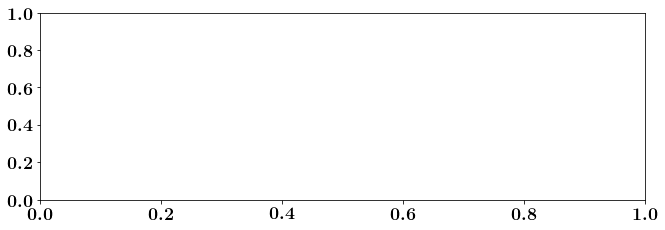

In [207]:
index = 112
image = X_valid[index,:].reshape(1,max_fft + DoE_shape,1)


print(image.shape)

cam = GradCAM(model, np.argmax(Y_valid[index]))
heatmap = cam.compute_heatmap(image).T
heatmap = np.repeat(heatmap,2,axis=0)
# frequencyInterval = 19.53125

plt.figure(figsize=(12,4))
ax = plt.gca()

frequencyInterval = 10000/2048

xi = np.arange(-0.0, max_fft * frequencyInterval,frequencyInterval)
yi = np.linspace(np.amin(image[0]),np.amax(image[0]),2)


X, Y = np.meshgrid(xi, yi)
plt.pcolormesh(X,Y,heatmap,cmap='bone',alpha=1)
plt.plot(xi,image[0][0,:,:])
ax.grid(False)
plt.xlabel(r'\textbf{Frequency (Hz)}')
plt.ylabel(r'\textbf{FFT Magnitude}')
plt.title(r'\textbf{Bad Tool}',fontsize=22)
plt.savefig('Figures/Grad-CAM-Bad.png',transparent=True)  

plt.show()
